#Convierte XMLs asociados a las imágenes de formato COCO a LABELs en formato YOLO

# Preparación del entorno:

In [1]:
#@title Cargar Librerías
from IPython.display import Image, display
from PIL import Image as ImPIL
import numpy as np
import os
import cv2
import os.path
import datetime

import tensorflow as tf
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import xml.etree.cElementTree as ET

print ("Librerías cargadas.")

Librerías cargadas.


In [2]:
#@title Montar Drive
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Configuración del entorno:

In [3]:
#@title Definir parámetros a utilizar

#@markdown Parámetros de Archivos:
drive_path = "/content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/Generados" #@param {type:"string"}

ext_archivo_XML = ".xml" #@param {type:"string"}

if "." not in ext_archivo_XML:
  ext_archivo_XML = "." + ext_archivo_XML

ext_archivo_LABEL = ".txt" #@param {type:"string"}

if "." not in ext_archivo_LABEL:
  ext_archivo_LABEL = "." + ext_archivo_LABEL

class_list_path = "/content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/classes.txt" #@param {type:"string"}


print("Parámetros definidos.")


# definición de colores standard para clases
colors = [
      'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
      'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
      'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
      'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
      'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
      'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
      'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
      'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
      'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
      'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
      'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
      'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
      'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
      'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
      'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
      'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
      'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
      'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
      'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
      'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
      'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
      'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
      'WhiteSmoke', 'Yellow', 'YellowGreen'
  ]


print("Colores definidos: ", len(colors))

Parámetros definidos.
Colores definidos:  126


# Generación de LABELs en base a XMLs disponibles:

In [4]:
#@title Convertir archivos XMLs a formato LABELs


def convert_bbox_to_yolo(size, box):
    # size = (width, height)
    # box = (xmin, ymin, xmax, ymax)
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x_center_abs = (box[0] + box[2]) / 2.0
    y_center_abs = (box[1] + box[3]) / 2.0
    width_abs = box[2] - box[0]
    height_abs = box[3] - box[1]
    x_center = x_center_abs * dw
    y_center = y_center_abs * dh
    width = width_abs * dw
    height = height_abs * dh
    return (x_center, y_center, width, height)

def convert_yolo_to_bbox(yolo, image_size):
    # yolo = (x_center, y_center, width, height)
    # image_size = (dw, dh)
    dw, dh = image_size
    x, y, w, h = yolo
    x1 = int((x - w / 2) * dw)
    x2 = int((x + w / 2) * dw)
    y1 = int((y - h / 2) * dh)
    y2 = int((y + h / 2) * dh)
    if x1 < 0:
        x1 = 0
    if x2 > dw - 1:
        x2 = dw - 1
    if y1 < 0:
        y1 = 0
    if y2 > dh - 1:
        y2 = dh - 1
    # (xmin, ymin, xmax, ymax)
    return (x1, y1, x2, y2)


def convert_xml_to_yolo(xml_dir, xml_file, ext_YOLO, class_list):
    tree = ET.parse(xml_dir + '/' + xml_file)
    root = tree.getroot()
    # obtiene tamaño imagen
    image_width = int(root.find('size').find('width').text)
    image_height = int(root.find('size').find('height').text)
    image_size = (image_width, image_height)
    # convierte formato
    yolo_annotations = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_list:
            class_list.append( class_name )
        class_id = class_list.index(class_name)
        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)
        bbox_yolo = convert_bbox_to_yolo(image_size, (xmin, ymin, xmax, ymax))
        yolo_annotations.append(f"{class_id} {' '.join([f'{coord:.6f}' for coord in bbox_yolo])}")
    # graba nuevo archivo
    base_filename = os.path.splitext(os.path.basename(xml_file))[0]
    output_yolo_path = os.path.join(xml_dir, f"{base_filename}{ext_YOLO}")
    with open(output_yolo_path, 'w') as f:
        for annotation_line in yolo_annotations:
            f.write(annotation_line + '\n')
    return class_list

def process_XMLs(xml_dir, ext_archivo_XML, ext_archivo_LABEL):
    #"Reads all XML files, generated by labelImg, from a directory and generates a single CSV file"""
    class_list = []
    annotations = []
    xmlFileList = [ fn for fn in os.listdir(xml_dir) if os.path.splitext(fn)[1].lower() in [ext_archivo_XML] ]
    total = len(xmlFileList)
    auxMostrarTotal = (total//20)
    if auxMostrarTotal == 0:
      auxMostrarTotal = 1
    cant = 0
    print("\t XMLs a procesar en ", xml_dir, ": ", total)
    for xml_file in xmlFileList:
        cant = cant + 1
        if (cant % auxMostrarTotal) == 0:
          print("\t\t ya se procesaron  ", cant, " xmls")
        # convierte
        class_list = convert_xml_to_yolo(xml_dir, xml_file, ext_archivo_LABEL, class_list)
    print("\t -> procesado. ")
    return class_list

def save_class_list(class_list, txt_path):
    with open(txt_path, "w+") as f:
        for id, cl in enumerate(class_list):
            strGrabar = str(id) + ":" + str(cl)
            print("\t", strGrabar)
            f.write( strGrabar + "\n" )
    print("\t -> generado. ")


print("\n-- procesando ", drive_path,": ")
class_list = process_XMLs(drive_path, ext_archivo_XML, ext_archivo_LABEL)

print("\n-- generando ", class_list_path,": ")
save_class_list(class_list, class_list_path)



-- procesando  /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/Generados : 
	 XMLs a procesar en  /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/Generados :  1000
		 ya se procesaron   50  xmls
		 ya se procesaron   100  xmls
		 ya se procesaron   150  xmls
		 ya se procesaron   200  xmls
		 ya se procesaron   250  xmls
		 ya se procesaron   300  xmls
		 ya se procesaron   350  xmls
		 ya se procesaron   400  xmls
		 ya se procesaron   450  xmls
		 ya se procesaron   500  xmls
		 ya se procesaron   550  xmls
		 ya se procesaron   600  xmls
		 ya se procesaron   650  xmls
		 ya se procesaron   700  xmls
		 ya se procesaron   750  xmls
		 ya se procesaron   800  xmls
		 ya se procesaron   850  xmls
		 ya se procesaron   900  xmls
		 ya se procesaron   950  xmls
		 ya se procesaron   1000  xmls
	 -> procesado. 

-- generando  /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/classes.txt : 
	 0:2
	 1:0
	 2:8
	 3:6
	 4:4
	 5:3
	 6:1
	 7:7
	 8:9
	 9:5
	

# Prueba de LABELs generadas:

In [8]:
#@title Determinar LABELs generadas a revisar
drive.mount('/content/gdrive', force_remount=True)


levantarSoloDA =  False #param {type:"boolean"}
filtrar_prefijo_inicial_caso_generado = "" #param {type:"string"}


#@markdown Parámetros sobre Información a Mostrar:
cantMuestraMostrar =  50#@param {type:"integer"}
mostrarImagenOriginal = False #@param {type:"boolean"}
extraerObjetos = False #param {type:"boolean"}
mostrarObjetosEnImagen = True #param {type:"boolean"}
calcularCantTipoObjetos =  True #param {type:"boolean"}

print("Parámetros definidos.")




# define la carpeta donde están las imágenes para procesar
data_dir_path = drive_path
image_dir_path = data_dir_path

# levanta los XML  para procesar
all_label_array = [ fn for fn in os.listdir( data_dir_path ) if fn.endswith(ext_archivo_LABEL)  ]
if levantarSoloDA and len(all_label_array)>0:
  all_label_array = [ fn for fn in all_label_array if fn.startswith('da')  ]
if filtrar_prefijo_inicial_caso_generado != "" and len(all_label_array)>0:
  all_label_array = [ fn for fn in all_label_array if fn.find('_'+ filtrar_prefijo_inicial_caso_generado +'_')>0 ]

# desordena y toma algunos al azar
if len(all_label_array)>cantMuestraMostrar:
  np.random.shuffle(all_label_array)
  mostrar_label_array, _ = np.split(np.array(all_label_array), [cantMuestraMostrar])
else:
  mostrar_label_array = np.array(all_label_array)

#print("> LABEL a probar: ", len(all_label_array))
print("> LABEL a mostrar: ", len(mostrar_label_array))

if len(mostrar_label_array) > 0:
  fechasCreacion = [ datetime.datetime.fromtimestamp(os.path.getmtime(data_dir_path + '/' + ar)) for ar in mostrar_label_array]
  print("> Fechas de creación de XML a mostrar entre ",   min( fechasCreacion ), " y ", max( fechasCreacion ))


Mounted at /content/gdrive
Parámetros definidos.
> LABEL a mostrar:  50
> Fechas de creación de XML a mostrar entre  2025-09-30 16:03:49  y  2025-09-30 16:04:02




 1 >  cartel_915118990201913.txt
	 - 8 (0.067416, 0.115839, 0.069459, 0.184397) -> 9 (32, 9, 100, 87)
	 - 6 (0.194586, 0.150118, 0.103166, 0.262411) -> 1 (139, 7, 240, 118)
	 - 9 (0.321246, 0.27305, 0.103166, 0.262411) -> 5 (264, 60, 364, 171)
	 - 6 (0.467314, 0.254137, 0.127681, 0.319149) -> 1 (395, 39, 520, 174)
	 - 6 (0.607252, 0.143026, 0.074566, 0.196217) -> 1 (557, 19, 630, 101)
	 - 2 (0.756895, 0.361702, 0.14096, 0.349882) -> 8 (672, 78, 810, 226)
	 - 8 (0.875894, 0.083924, 0.035751, 0.106383) -> 9 (840, 12, 875, 57)
	 - 8 (0.964249, 0.096927, 0.040858, 0.118203) -> 9 (923, 16, 963, 66)
	 - 1 (0.047497, 0.663121, 0.066394, 0.177305) -> 0 (13, 243, 78, 318)
	 - 0 (0.170582, 0.723404, 0.067416, 0.179669) -> 2 (133, 267, 199, 343)
	 - 1 (0.316139, 0.771868, 0.141982, 0.352246) -> 0 (239, 252, 379, 401)
	 - 6 (0.457099, 0.724586, 0.08478, 0.219858) -> 1 (406, 259, 488, 352)
	 - 8 (0.644025, 0.741135, 0.11951, 0.300236) -> 9 (572, 250, 689, 377)
	 - 6 (0.811032, 0.817967, 0.12666, 

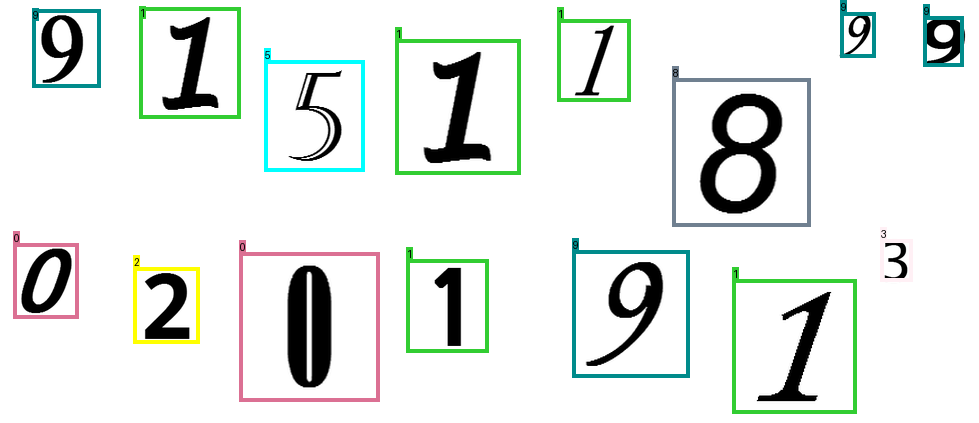



 2 >  cartel_646673243213132.txt
	 - 3 (0.086335, 0.244413, 0.102754, 0.298883) -> 6 (33, 33, 130, 140)
	 - 4 (0.23464, 0.325419, 0.121822, 0.349162) -> 4 (164, 54, 279, 179)
	 - 3 (0.404131, 0.322626, 0.115466, 0.332402) -> 6 (326, 56, 435, 175)
	 - 3 (0.582097, 0.303073, 0.104873, 0.304469) -> 6 (499, 54, 598, 163)
	 - 7 (0.730932, 0.22905, 0.125, 0.357542) -> 7 (630, 17, 748, 145)
	 - 5 (0.911547, 0.344972, 0.145127, 0.410615) -> 3 (792, 49, 929, 197)
	 - 0 (0.076271, 0.790503, 0.125, 0.357542) -> 2 (12, 219, 130, 347)
	 - 4 (0.180085, 0.639665, 0.023305, 0.089385) -> 4 (159, 213, 181, 244)
	 - 5 (0.244174, 0.666201, 0.022246, 0.086592) -> 3 (220, 222, 241, 253)
	 - 0 (0.365466, 0.756983, 0.07839, 0.234637) -> 2 (307, 228, 381, 312)
	 - 6 (0.435911, 0.652235, 0.013771, 0.064246) -> 1 (405, 222, 417, 245)
	 - 5 (0.508475, 0.72067, 0.036017, 0.122905) -> 3 (463, 235, 497, 279)
	 - 6 (0.57839, 0.648045, 0.021186, 0.083799) -> 1 (536, 217, 555, 247)
	 - 5 (0.692797, 0.787709, 0.129237

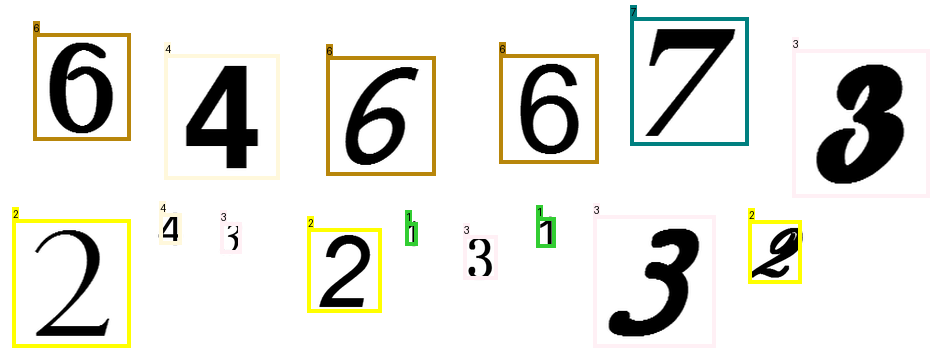



 3 >  cartel_941225159963437.txt
	 - 8 (0.055147, 0.205952, 0.087185, 0.221429) -> 9 (10, 39, 94, 132)
	 - 4 (0.252626, 0.227381, 0.141807, 0.345238) -> 4 (172, 23, 308, 168)
	 - 6 (0.455882, 0.211905, 0.10084, 0.252381) -> 1 (385, 36, 481, 142)
	 - 0 (0.575105, 0.132143, 0.070378, 0.183333) -> 2 (514, 17, 580, 93)
	 - 0 (0.708508, 0.24881, 0.110294, 0.27381) -> 2 (621, 47, 726, 162)
	 - 9 (0.81145, 0.075, 0.043067, 0.121429) -> 5 (752, 5, 793, 57)
	 - 6 (0.892332, 0.177381, 0.061975, 0.164286) -> 1 (819, 39, 879, 109)
	 - 9 (0.965861, 0.09881, 0.036765, 0.107143) -> 5 (901, 19, 936, 64)
	 - 8 (0.109244, 0.688095, 0.138655, 0.338095) -> 9 (38, 217, 170, 359)
	 - 8 (0.321954, 0.80119, 0.143908, 0.35) -> 9 (238, 262, 375, 409)
	 - 3 (0.426996, 0.513095, 0.022059, 0.07381) -> 6 (396, 199, 417, 230)
	 - 5 (0.480042, 0.492857, 0.016807, 0.061905) -> 3 (448, 193, 465, 219)
	 - 4 (0.594538, 0.757143, 0.128151, 0.314286) -> 4 (505, 252, 627, 384)
	 - 5 (0.785189, 0.64881, 0.122899, 0.302381)

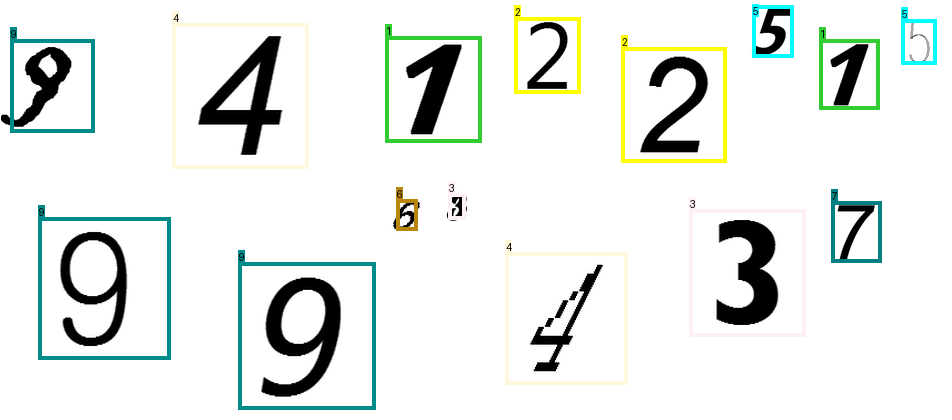



 4 >  cartel_285578964945009.txt
	 - 0 (0.096824, 0.27599, 0.128074, 0.334158) -> 2 (32, 44, 157, 178)
	 - 2 (0.247951, 0.306931, 0.112705, 0.29703) -> 8 (187, 64, 297, 184)
	 - 9 (0.412398, 0.318069, 0.13627, 0.35396) -> 5 (336, 56, 469, 199)
	 - 9 (0.535861, 0.133663, 0.05123, 0.148515) -> 5 (498, 23, 548, 83)
	 - 7 (0.70748, 0.278465, 0.134221, 0.34901) -> 7 (625, 41, 756, 182)
	 - 2 (0.823258, 0.12005, 0.054303, 0.155941) -> 8 (776, 17, 829, 80)
	 - 8 (0.928791, 0.251238, 0.11168, 0.294554) -> 9 (852, 42, 960, 161)
	 - 3 (0.133197, 0.769802, 0.129098, 0.336634) -> 6 (67, 242, 193, 379)
	 - 4 (0.272541, 0.747525, 0.096311, 0.257426) -> 4 (219, 250, 312, 354)
	 - 8 (0.358607, 0.628713, 0.020492, 0.074257) -> 9 (340, 239, 360, 268)
	 - 4 (0.426742, 0.674505, 0.058402, 0.165842) -> 4 (388, 238, 445, 306)
	 - 9 (0.573258, 0.800743, 0.134221, 0.34901) -> 5 (493, 253, 624, 394)
	 - 1 (0.735143, 0.696782, 0.11168, 0.294554) -> 0 (662, 222, 771, 340)
	 - 1 (0.827869, 0.594059, 0.022541, 0

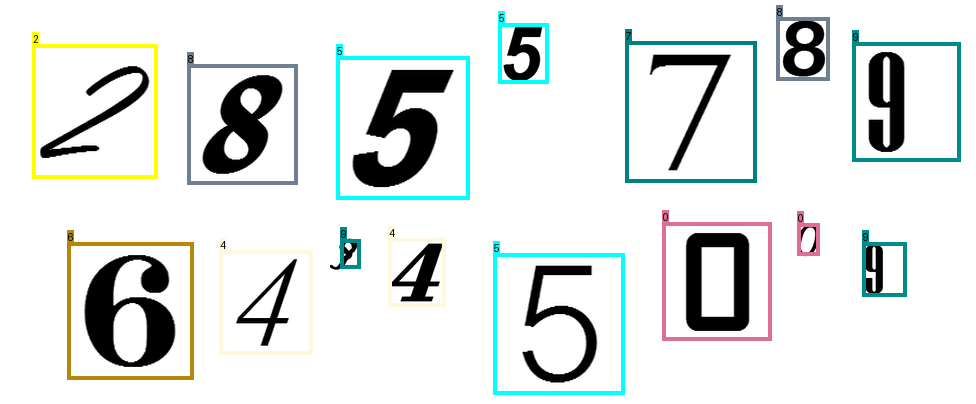



 5 >  cartel_121031188668892.txt
	 - 6 (0.080321, 0.211823, 0.128514, 0.339901) -> 1 (15, 17, 143, 155)
	 - 0 (0.290161, 0.357143, 0.138554, 0.364532) -> 2 (220, 71, 358, 219)
	 - 6 (0.487952, 0.248768, 0.11245, 0.300493) -> 1 (430, 39, 542, 161)
	 - 1 (0.587349, 0.078818, 0.016064, 0.064039) -> 0 (576, 19, 592, 45)
	 - 5 (0.685743, 0.179803, 0.078313, 0.216749) -> 3 (644, 28, 721, 117)
	 - 6 (0.7751, 0.05665, 0.02008, 0.073892) -> 1 (761, 7, 781, 37)
	 - 6 (0.927209, 0.309113, 0.115462, 0.307882) -> 1 (866, 62, 981, 187)
	 - 2 (0.105924, 0.703202, 0.103414, 0.278325) -> 8 (54, 229, 157, 341)
	 - 2 (0.199297, 0.612069, 0.019076, 0.071429) -> 8 (188, 233, 207, 263)
	 - 3 (0.274598, 0.703202, 0.053213, 0.155172) -> 6 (246, 254, 299, 316)
	 - 3 (0.408133, 0.80665, 0.12751, 0.337438) -> 6 (343, 258, 470, 395)
	 - 2 (0.531627, 0.646552, 0.053213, 0.155172) -> 8 (503, 231, 556, 294)
	 - 2 (0.617972, 0.631773, 0.043173, 0.130542) -> 8 (593, 229, 637, 282)
	 - 8 (0.727912, 0.763547, 0.076305

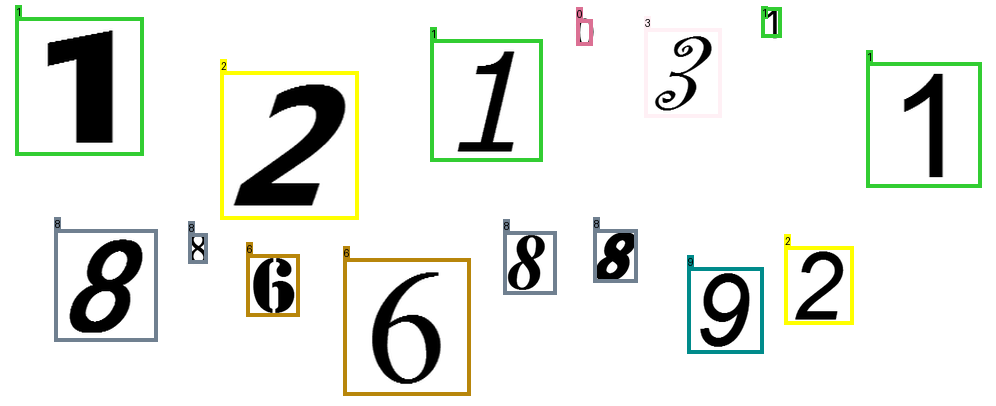



 6 >  cartel_106936539958587.txt
	 - 6 (0.034413, 0.117333, 0.024291, 0.090667) -> 1 (22, 26, 45, 60)
	 - 1 (0.1083, 0.144, 0.050607, 0.16) -> 0 (82, 23, 132, 83)
	 - 3 (0.244433, 0.265333, 0.13664, 0.386667) -> 6 (173, 26, 308, 171)
	 - 8 (0.40081, 0.136, 0.072874, 0.218667) -> 9 (360, 9, 432, 92)
	 - 5 (0.5, 0.168, 0.072874, 0.218667) -> 3 (458, 21, 529, 104)
	 - 3 (0.574393, 0.1, 0.029352, 0.104) -> 6 (553, 18, 582, 57)
	 - 9 (0.737854, 0.346667, 0.129555, 0.368) -> 5 (664, 61, 792, 199)
	 - 5 (0.86083, 0.228, 0.067814, 0.205333) -> 3 (816, 47, 884, 123)
	 - 8 (0.959514, 0.112, 0.050607, 0.16) -> 9 (922, 12, 972, 72)
	 - 8 (0.044028, 0.694667, 0.055668, 0.173333) -> 9 (15, 228, 70, 293)
	 - 9 (0.111336, 0.682667, 0.032389, 0.112) -> 5 (93, 235, 126, 277)
	 - 2 (0.199899, 0.710667, 0.051619, 0.162667) -> 8 (172, 236, 222, 297)
	 - 9 (0.263664, 0.625333, 0.017206, 0.072) -> 5 (252, 220, 268, 247)
	 - 2 (0.407389, 0.817333, 0.1083, 0.312) -> 8 (349, 247, 456, 364)
	 - 7 (0.521761, 0.

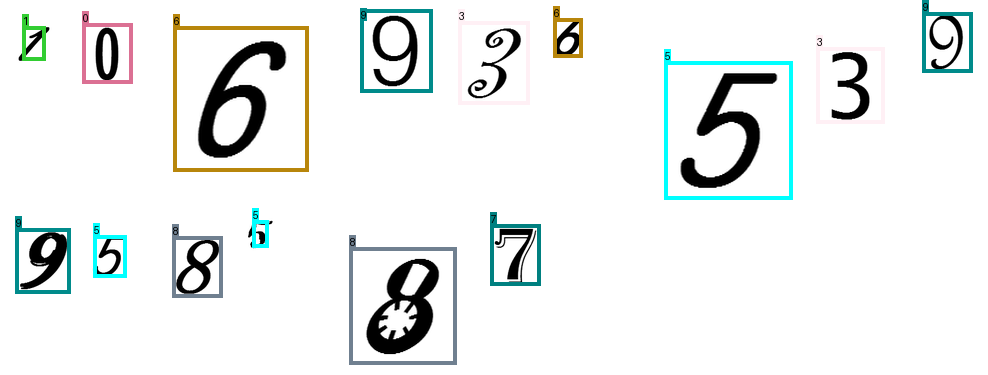



 7 >  cartel_424578301667977.txt
	 - 4 (0.068063, 0.132576, 0.071204, 0.147727) -> 4 (31, 31, 99, 109)
	 - 0 (0.153927, 0.066288, 0.020942, 0.056818) -> 2 (137, 20, 157, 50)
	 - 4 (0.267016, 0.151515, 0.094241, 0.189394) -> 4 (210, 29, 300, 129)
	 - 9 (0.451832, 0.211174, 0.139267, 0.270833) -> 5 (364, 39, 497, 182)
	 - 7 (0.632984, 0.247159, 0.135079, 0.263258) -> 7 (539, 60, 668, 200)
	 - 2 (0.809424, 0.153409, 0.121466, 0.238636) -> 8 (714, 18, 830, 143)
	 - 5 (0.920419, 0.064394, 0.023037, 0.060606) -> 3 (867, 18, 890, 50)
	 - 1 (0.14555, 0.63447, 0.125654, 0.246212) -> 0 (79, 270, 199, 400)
	 - 6 (0.339791, 0.618371, 0.126702, 0.248106) -> 1 (264, 260, 385, 391)
	 - 3 (0.473298, 0.551136, 0.052356, 0.113636) -> 6 (426, 260, 476, 320)
	 - 3 (0.657592, 0.626894, 0.144503, 0.280303) -> 6 (559, 257, 697, 405)
	 - 7 (0.84712, 0.566288, 0.087958, 0.17803) -> 7 (766, 252, 850, 345)
	 - 8 (0.950785, 0.560606, 0.067016, 0.140152) -> 9 (875, 258, 939, 333)
	 - 7 (0.084293, 0.900568, 0.070

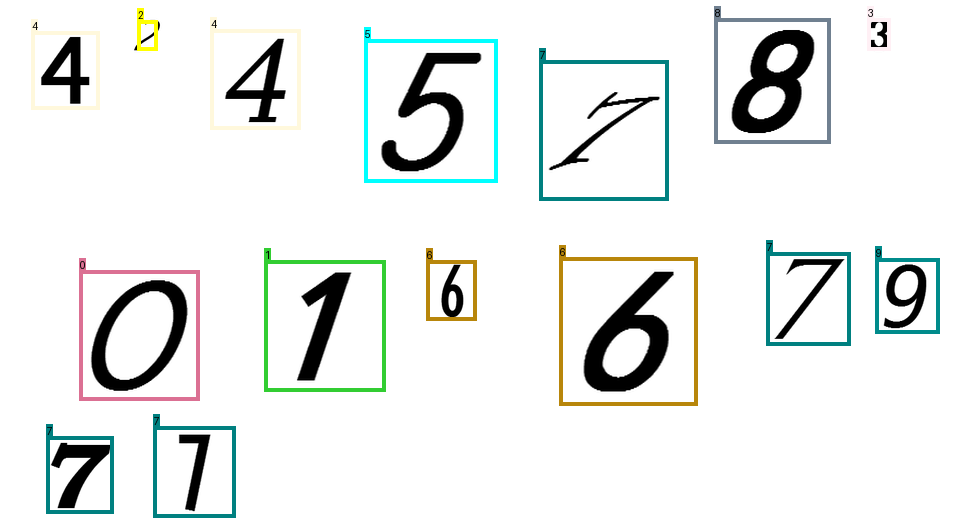



 8 >  cartel_108599210595280.txt
	 - 6 (0.084551, 0.337143, 0.108559, 0.325714) -> 1 (29, 61, 132, 175)
	 - 1 (0.235386, 0.261429, 0.097077, 0.294286) -> 0 (178, 40, 271, 143)
	 - 2 (0.360647, 0.155714, 0.063674, 0.202857) -> 8 (314, 18, 375, 89)
	 - 9 (0.524008, 0.311429, 0.135699, 0.4) -> 5 (436, 39, 566, 179)
	 - 8 (0.637265, 0.155714, 0.038622, 0.134286) -> 9 (591, 30, 628, 77)
	 - 8 (0.745825, 0.255714, 0.086639, 0.265714) -> 9 (673, 42, 756, 135)
	 - 0 (0.914405, 0.257143, 0.139875, 0.411429) -> 2 (808, 17, 943, 162)
	 - 6 (0.080376, 0.682857, 0.060543, 0.194286) -> 1 (48, 204, 106, 273)
	 - 1 (0.163883, 0.631429, 0.029228, 0.108571) -> 0 (142, 202, 171, 240)
	 - 9 (0.289666, 0.784286, 0.126305, 0.374286) -> 5 (216, 209, 338, 340)
	 - 8 (0.450939, 0.782857, 0.087683, 0.268571) -> 9 (389, 227, 473, 320)
	 - 9 (0.601253, 0.785714, 0.123173, 0.365714) -> 5 (517, 210, 635, 338)
	 - 0 (0.741649, 0.707143, 0.051148, 0.168571) -> 2 (685, 218, 734, 276)
	 - 2 (0.824113, 0.658571, 0.038

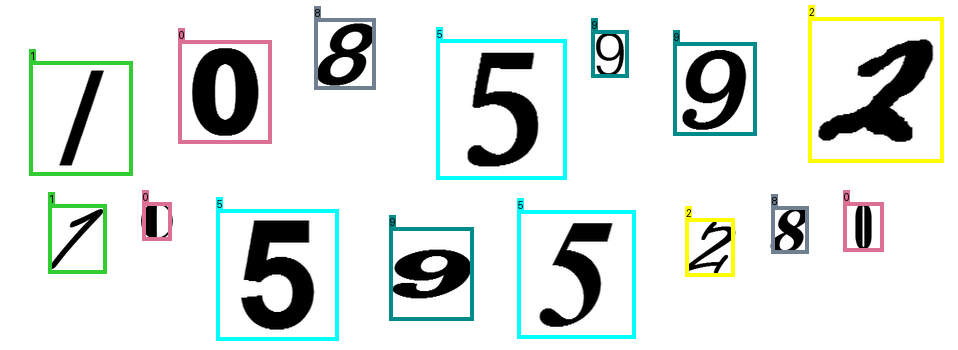



 9 >  cartel_117868303592351.txt
	 - 6 (0.064115, 0.124658, 0.048708, 0.161644) -> 1 (39, 16, 88, 75)
	 - 6 (0.17992, 0.276712, 0.109344, 0.328767) -> 1 (125, 40, 235, 160)
	 - 7 (0.270875, 0.1, 0.018887, 0.079452) -> 7 (263, 22, 282, 50)
	 - 2 (0.409543, 0.30137, 0.133201, 0.394521) -> 8 (345, 37, 479, 182)
	 - 3 (0.581511, 0.249315, 0.099404, 0.30137) -> 6 (534, 35, 635, 146)
	 - 2 (0.677932, 0.123288, 0.027833, 0.10411) -> 8 (667, 26, 695, 64)
	 - 5 (0.820577, 0.247945, 0.128231, 0.380822) -> 3 (761, 20, 890, 159)
	 - 1 (0.960239, 0.145205, 0.049702, 0.164384) -> 0 (941, 22, 991, 82)
	 - 5 (0.048708, 0.621918, 0.053678, 0.175342) -> 3 (22, 195, 76, 258)
	 - 9 (0.173459, 0.732877, 0.082505, 0.254795) -> 5 (132, 221, 215, 314)
	 - 8 (0.269384, 0.679452, 0.043738, 0.147945) -> 9 (249, 221, 293, 274)
	 - 0 (0.324553, 0.590411, 0.014911, 0.068493) -> 2 (319, 203, 334, 227)
	 - 5 (0.427435, 0.764384, 0.081511, 0.252055) -> 3 (388, 233, 470, 325)
	 - 9 (0.587972, 0.782192, 0.104374, 0.31

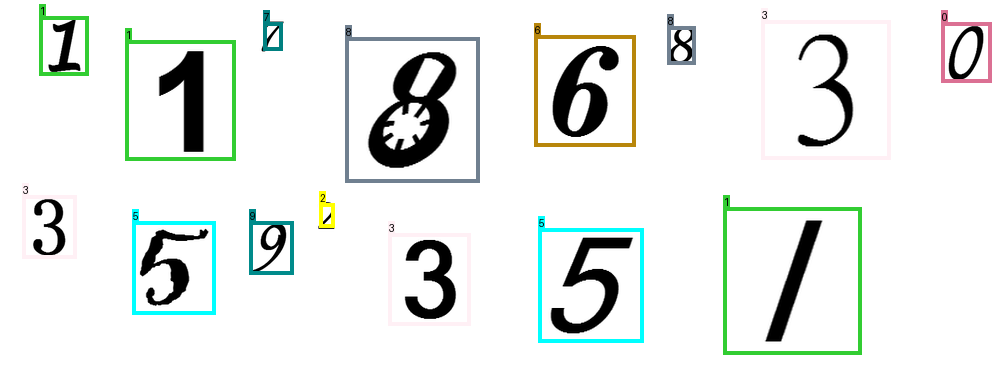



 10 >  cartel_694465238937658.txt
	 - 3 (0.08661, 0.245787, 0.092455, 0.272472) -> 6 (37, 39, 125, 136)
	 - 8 (0.195005, 0.234551, 0.073326, 0.22191) -> 9 (148, 44, 217, 123)
	 - 4 (0.329968, 0.279494, 0.11796, 0.339888) -> 4 (254, 38, 366, 159)
	 - 4 (0.425611, 0.088483, 0.026567, 0.098315) -> 4 (388, 13, 412, 49)
	 - 3 (0.476621, 0.094101, 0.028693, 0.103933) -> 6 (435, 14, 462, 52)
	 - 9 (0.567481, 0.19382, 0.057386, 0.179775) -> 5 (506, 36, 560, 100)
	 - 0 (0.673751, 0.269663, 0.104145, 0.303371) -> 2 (584, 41, 682, 150)
	 - 5 (0.806589, 0.179775, 0.089267, 0.264045) -> 3 (717, 16, 801, 110)
	 - 2 (0.937832, 0.231742, 0.092455, 0.272472) -> 8 (838, 34, 925, 131)
	 - 8 (0.08661, 0.726124, 0.120085, 0.345506) -> 9 (25, 197, 138, 320)
	 - 5 (0.202976, 0.632022, 0.036132, 0.123596) -> 3 (174, 202, 208, 246)
	 - 7 (0.31084, 0.672753, 0.064825, 0.199438) -> 7 (262, 204, 323, 275)
	 - 3 (0.447396, 0.814607, 0.108395, 0.314607) -> 6 (369, 234, 471, 346)
	 - 9 (0.603613, 0.66573, 0.074389

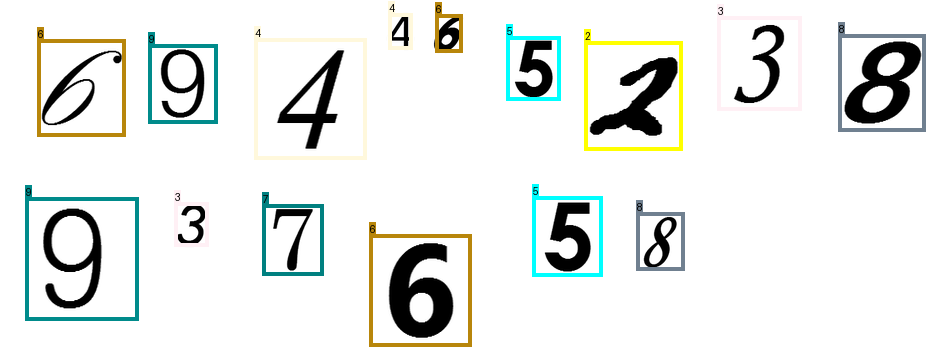



 11 >  cartel_047672450630647.txt
	 - 1 (0.116418, 0.255046, 0.125373, 0.249541) -> 0 (54, 71, 180, 206)
	 - 4 (0.255224, 0.088991, 0.070647, 0.148624) -> 4 (221, 8, 292, 89)
	 - 7 (0.340796, 0.057798, 0.022886, 0.06055) -> 7 (330, 15, 354, 47)
	 - 3 (0.51592, 0.241284, 0.134328, 0.266055) -> 6 (450, 58, 585, 203)
	 - 7 (0.664677, 0.253211, 0.117413, 0.234862) -> 7 (609, 74, 727, 201)
	 - 0 (0.840796, 0.187156, 0.125373, 0.249541) -> 2 (782, 34, 907, 169)
	 - 4 (0.083582, 0.53945, 0.137313, 0.27156) -> 4 (15, 220, 152, 368)
	 - 9 (0.199502, 0.487156, 0.042786, 0.097248) -> 5 (178, 238, 221, 292)
	 - 1 (0.321891, 0.641284, 0.118408, 0.236697) -> 0 (264, 284, 383, 413)
	 - 3 (0.497015, 0.558716, 0.124378, 0.247706) -> 6 (437, 237, 562, 372)
	 - 5 (0.609453, 0.454128, 0.020896, 0.056881) -> 3 (602, 231, 623, 262)
	 - 1 (0.653234, 0.448624, 0.016915, 0.049541) -> 0 (648, 231, 664, 258)
	 - 3 (0.814925, 0.559633, 0.127363, 0.253211) -> 6 (754, 235, 882, 373)
	 - 4 (0.946766, 0.5, 0.076617

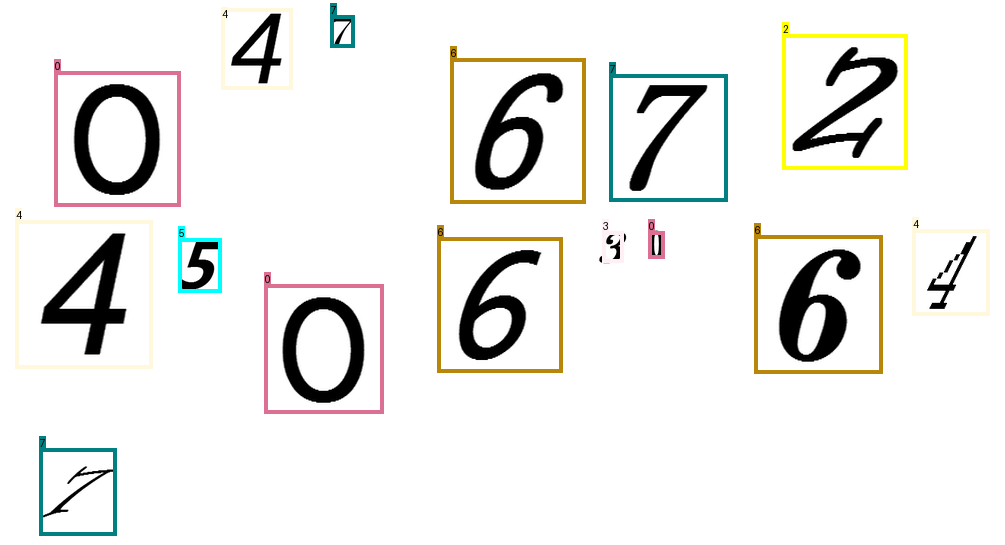



 12 >  cartel_026535631076289.txt
	 - 1 (0.059761, 0.211538, 0.069721, 0.307692) -> 0 (25, 14, 94, 94)
	 - 0 (0.177789, 0.282692, 0.072709, 0.319231) -> 2 (142, 31, 215, 114)
	 - 3 (0.3501, 0.294231, 0.128486, 0.534615) -> 6 (287, 7, 416, 146)
	 - 9 (0.494024, 0.323077, 0.077689, 0.338462) -> 5 (457, 39, 534, 128)
	 - 5 (0.625, 0.317308, 0.10259, 0.434615) -> 3 (575, 26, 679, 139)
	 - 9 (0.723606, 0.121154, 0.0249, 0.134615) -> 5 (714, 14, 739, 48)
	 - 3 (0.843625, 0.196154, 0.079681, 0.346154) -> 6 (806, 6, 886, 96)
	 - 5 (0.950199, 0.223077, 0.069721, 0.307692) -> 3 (918, 18, 988, 97)
	 - 6 (0.0249, 0.723077, 0.017928, 0.107692) -> 1 (15, 174, 33, 201)
	 - 1 (0.070219, 0.736538, 0.022908, 0.126923) -> 0 (59, 174, 81, 207)
	 - 7 (0.153386, 0.8, 0.073705, 0.323077) -> 7 (116, 165, 190, 250)
	 - 3 (0.225598, 0.732692, 0.016932, 0.103846) -> 6 (218, 176, 235, 203)
	 - 0 (0.268924, 0.711538, 0.025896, 0.138462) -> 2 (256, 166, 282, 202)
	 - 2 (0.339143, 0.713462, 0.032869, 0.165385) -> 

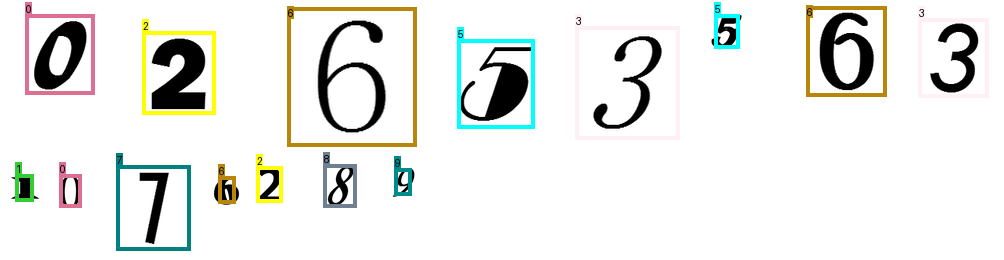



 13 >  cartel_204779648663403.txt
	 - 0 (0.089928, 0.161316, 0.122302, 0.207063) -> 2 (28, 35, 146, 164)
	 - 1 (0.308325, 0.17817, 0.127441, 0.215088) -> 0 (238, 43, 362, 177)
	 - 4 (0.446557, 0.122793, 0.060637, 0.110754) -> 4 (405, 42, 463, 110)
	 - 7 (0.554985, 0.102729, 0.049332, 0.093098) -> 7 (516, 35, 564, 93)
	 - 7 (0.672148, 0.120385, 0.061665, 0.11236) -> 7 (623, 39, 684, 109)
	 - 8 (0.748201, 0.048154, 0.036999, 0.073836) -> 9 (709, 7, 745, 52)
	 - 3 (0.884378, 0.222311, 0.13258, 0.223114) -> 6 (795, 68, 924, 207)
	 - 4 (0.128469, 0.457464, 0.115108, 0.195827) -> 4 (69, 223, 181, 346)
	 - 2 (0.315519, 0.479936, 0.135663, 0.227929) -> 8 (240, 228, 373, 370)
	 - 3 (0.471737, 0.484751, 0.084275, 0.147673) -> 6 (418, 255, 499, 348)
	 - 3 (0.635663, 0.570626, 0.140802, 0.235955) -> 6 (549, 282, 687, 428)
	 - 5 (0.816033, 0.487961, 0.094553, 0.163724) -> 3 (748, 252, 840, 354)
	 - 4 (0.93628, 0.478331, 0.096608, 0.166934) -> 4 (864, 246, 958, 350)
	 - 1 (0.080678, 0.846709, 0.08

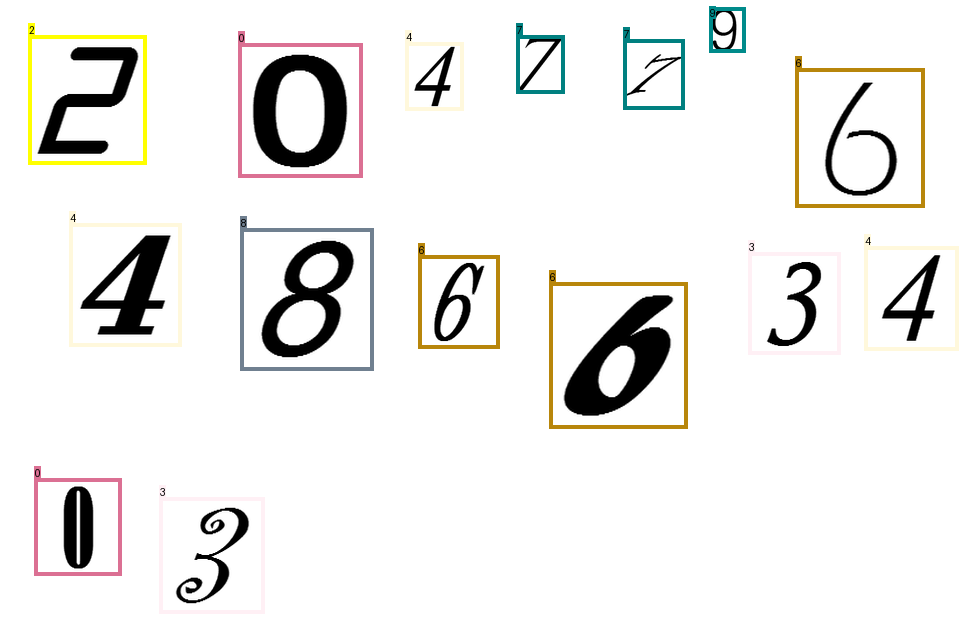



 14 >  cartel_522686335327893.txt
	 - 9 (0.1315, 0.284826, 0.117, 0.31592) -> 5 (73, 51, 190, 177)
	 - 0 (0.2705, 0.140547, 0.057, 0.166667) -> 2 (242, 22, 299, 89)
	 - 0 (0.4, 0.253731, 0.118, 0.318408) -> 2 (341, 37, 459, 165)
	 - 3 (0.5285, 0.143035, 0.047, 0.141791) -> 6 (505, 29, 551, 86)
	 - 2 (0.673, 0.218905, 0.128, 0.343284) -> 8 (609, 18, 737, 156)
	 - 3 (0.881, 0.248756, 0.118, 0.318408) -> 6 (822, 35, 940, 163)
	 - 5 (0.042, 0.614428, 0.046, 0.139303) -> 3 (19, 219, 65, 274)
	 - 5 (0.1225, 0.605721, 0.053, 0.156716) -> 3 (96, 211, 149, 274)
	 - 9 (0.209, 0.674129, 0.058, 0.169154) -> 5 (180, 236, 238, 304)
	 - 5 (0.2865, 0.623134, 0.051, 0.151741) -> 3 (260, 219, 312, 280)
	 - 0 (0.38, 0.706468, 0.072, 0.20398) -> 2 (344, 243, 416, 325)
	 - 7 (0.5155, 0.767413, 0.111, 0.300995) -> 7 (459, 248, 571, 369)
	 - 2 (0.6565, 0.662935, 0.109, 0.29602) -> 8 (602, 206, 711, 325)
	 - 8 (0.7725, 0.682836, 0.065, 0.186567) -> 9 (740, 237, 804, 312)
	 - 5 (0.924, 0.810945, 0.122, 0.328

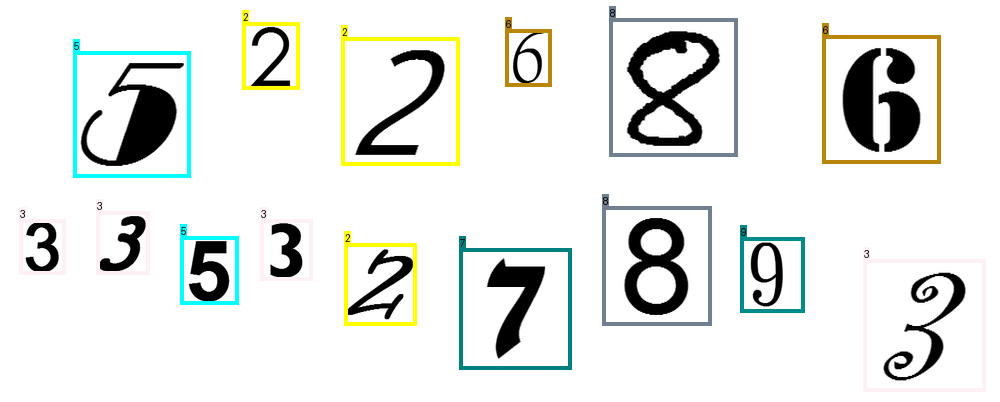



 15 >  cartel_260515832392625.txt
	 - 0 (0.134454, 0.191209, 0.128151, 0.29011) -> 2 (67, 21, 189, 153)
	 - 3 (0.289391, 0.306593, 0.131303, 0.296703) -> 6 (213, 71, 338, 206)
	 - 1 (0.435399, 0.253846, 0.110294, 0.252747) -> 0 (361, 57, 466, 172)
	 - 9 (0.567227, 0.250549, 0.102941, 0.237363) -> 5 (491, 59, 589, 167)
	 - 6 (0.720588, 0.136264, 0.07563, 0.18022) -> 1 (649, 21, 721, 103)
	 - 9 (0.815126, 0.072527, 0.042017, 0.10989) -> 5 (755, 7, 796, 57)
	 - 2 (0.944853, 0.176923, 0.078782, 0.186813) -> 8 (861, 38, 937, 122)
	 - 5 (0.044118, 0.593407, 0.054622, 0.136264) -> 3 (16, 239, 68, 301)
	 - 0 (0.120273, 0.557143, 0.028361, 0.081319) -> 2 (101, 234, 127, 272)
	 - 5 (0.194853, 0.598901, 0.047269, 0.120879) -> 3 (163, 244, 208, 299)
	 - 8 (0.294643, 0.689011, 0.091387, 0.213187) -> 9 (236, 264, 324, 362)
	 - 0 (0.422269, 0.626374, 0.065126, 0.158242) -> 2 (371, 249, 433, 321)
	 - 3 (0.578782, 0.815385, 0.144958, 0.325275) -> 6 (482, 297, 620, 445)
	 - 0 (0.727416, 0.579121, 0.06

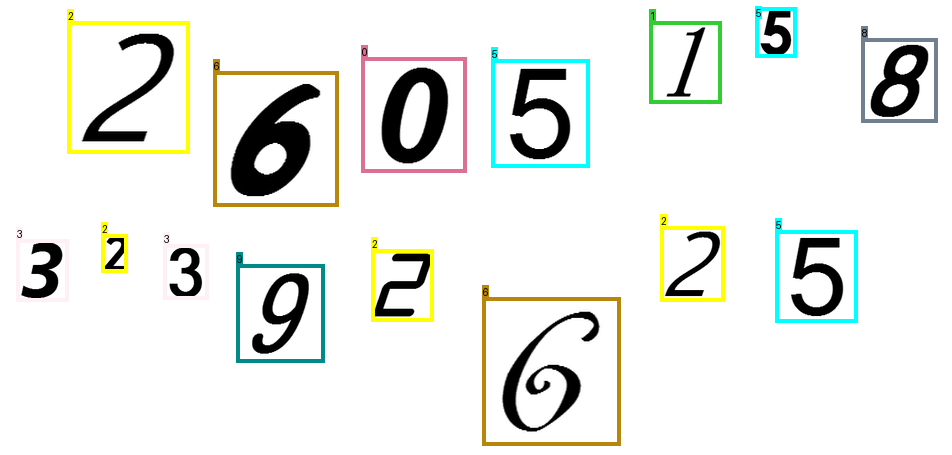



 16 >  cartel_087789408581960.txt
	 - 1 (0.05137, 0.220798, 0.05773, 0.196581) -> 0 (23, 43, 82, 112)
	 - 2 (0.13454, 0.217949, 0.055773, 0.190883) -> 8 (108, 43, 165, 110)
	 - 7 (0.205969, 0.078348, 0.016634, 0.076923) -> 7 (202, 14, 219, 41)
	 - 7 (0.28865, 0.210826, 0.056751, 0.193732) -> 7 (266, 39, 324, 107)
	 - 2 (0.428571, 0.236467, 0.084149, 0.273504) -> 8 (394, 34, 480, 130)
	 - 8 (0.543053, 0.205128, 0.072407, 0.239316) -> 9 (518, 29, 592, 113)
	 - 4 (0.615949, 0.07265, 0.016634, 0.076923) -> 4 (620, 12, 637, 39)
	 - 1 (0.699609, 0.222222, 0.074364, 0.245014) -> 0 (677, 34, 753, 120)
	 - 2 (0.866928, 0.333333, 0.107632, 0.34188) -> 8 (831, 56, 941, 176)
	 - 9 (0.970646, 0.14245, 0.029354, 0.11396) -> 5 (977, 29, 1007, 69)
	 - 2 (0.042564, 0.631054, 0.028376, 0.111111) -> 8 (29, 201, 58, 240)
	 - 6 (0.15411, 0.801994, 0.106654, 0.339031) -> 1 (103, 221, 212, 340)
	 - 8 (0.311644, 0.773504, 0.08317, 0.270655) -> 9 (276, 223, 361, 318)
	 - 3 (0.400685, 0.705128, 0.051859, 0.17

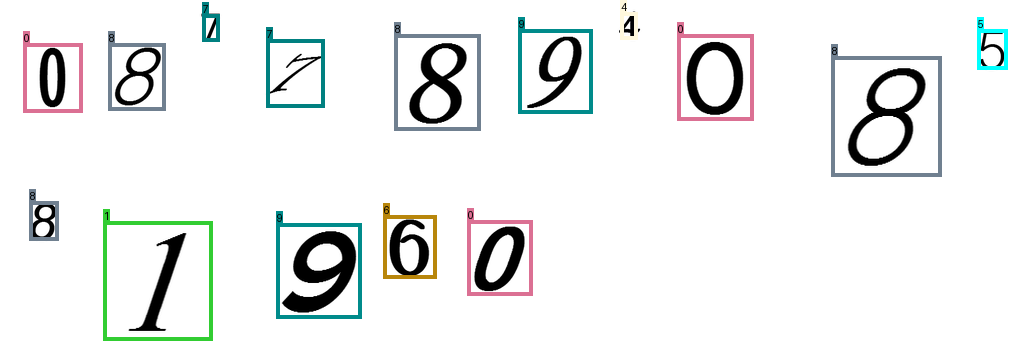



 17 >  cartel_985094736706122.txt
	 - 8 (0.074457, 0.19337, 0.099276, 0.195212) -> 9 (23, 51, 119, 157)
	 - 2 (0.178387, 0.142726, 0.06515, 0.134438) -> 8 (141, 41, 204, 114)
	 - 9 (0.27456, 0.094843, 0.05274, 0.112339) -> 5 (239, 20, 290, 81)
	 - 1 (0.465874, 0.150092, 0.143744, 0.274401) -> 0 (380, 7, 520, 155)
	 - 8 (0.702172, 0.211786, 0.134436, 0.257827) -> 9 (614, 44, 744, 184)
	 - 4 (0.83092, 0.164825, 0.079628, 0.160221) -> 4 (764, 45, 841, 132)
	 - 7 (0.94726, 0.103131, 0.074457, 0.151013) -> 7 (880, 15, 952, 97)
	 - 5 (0.058428, 0.424494, 0.038263, 0.086556) -> 3 (37, 207, 75, 254)
	 - 3 (0.153568, 0.459484, 0.046536, 0.101289) -> 6 (126, 221, 171, 276)
	 - 7 (0.244054, 0.511971, 0.074457, 0.151013) -> 7 (200, 237, 272, 319)
	 - 1 (0.422958, 0.543278, 0.1303, 0.25046) -> 0 (346, 227, 472, 362)
	 - 3 (0.615305, 0.604052, 0.128232, 0.246777) -> 6 (532, 261, 657, 395)
	 - 6 (0.749741, 0.445672, 0.072389, 0.14733) -> 1 (689, 201, 759, 281)
	 - 0 (0.894002, 0.623389, 0.141675, 0

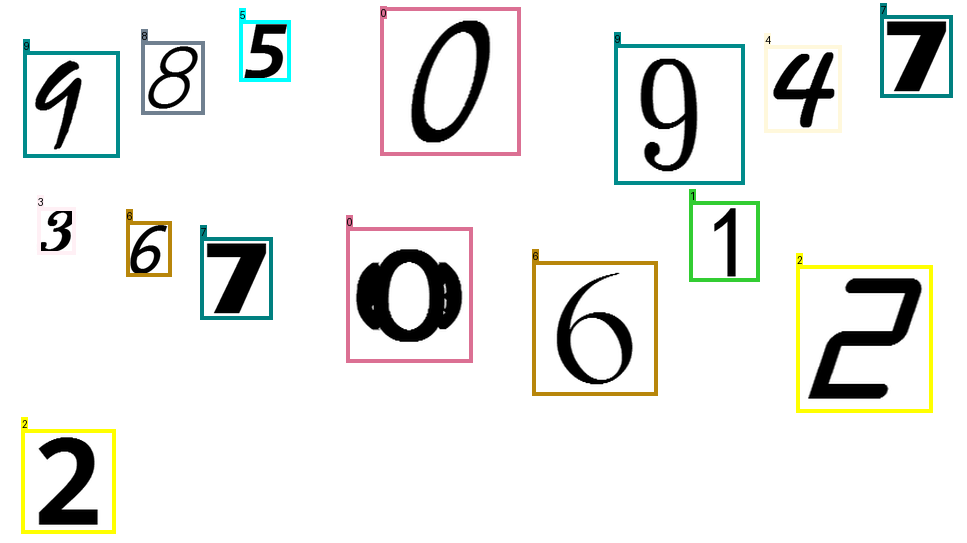



 18 >  cartel_476497047136246.txt
	 - 4 (0.030917, 0.089855, 0.03838, 0.133333) -> 4 (10, 8, 47, 53)
	 - 7 (0.1258, 0.165217, 0.061834, 0.197101) -> 7 (89, 22, 147, 90)
	 - 3 (0.246802, 0.227536, 0.08209, 0.252174) -> 6 (193, 34, 270, 121)
	 - 4 (0.382196, 0.236232, 0.105544, 0.315942) -> 4 (308, 27, 407, 136)
	 - 8 (0.515991, 0.223188, 0.089552, 0.272464) -> 9 (441, 29, 525, 123)
	 - 7 (0.641791, 0.115942, 0.057569, 0.185507) -> 7 (575, 8, 628, 71)
	 - 1 (0.742537, 0.157971, 0.047974, 0.15942) -> 0 (673, 27, 718, 81)
	 - 4 (0.833689, 0.228986, 0.063966, 0.202899) -> 4 (752, 44, 812, 114)
	 - 7 (0.937633, 0.25942, 0.092751, 0.281159) -> 7 (835, 40, 922, 137)
	 - 6 (0.102345, 0.730435, 0.140725, 0.411594) -> 1 (29, 181, 161, 323)
	 - 5 (0.21162, 0.54058, 0.013859, 0.066667) -> 3 (191, 175, 204, 198)
	 - 3 (0.352345, 0.801449, 0.114072, 0.33913) -> 6 (276, 217, 383, 334)
	 - 0 (0.471748, 0.627536, 0.058635, 0.188406) -> 2 (414, 183, 469, 248)
	 - 4 (0.547441, 0.523188, 0.028785, 0.1072

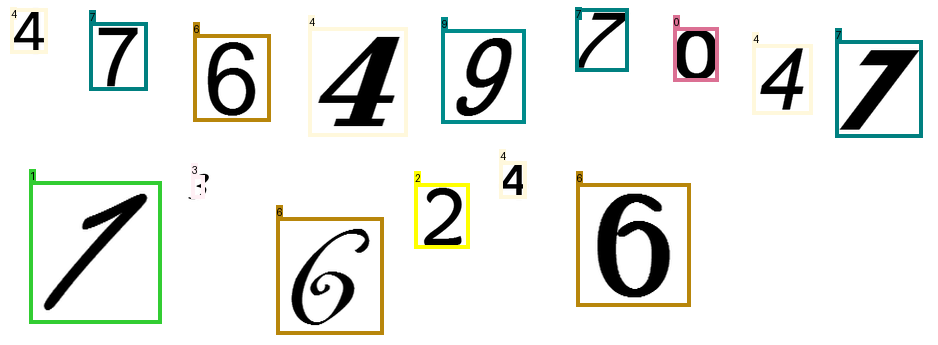



 19 >  cartel_476366811893681.txt
	 - 4 (0.037554, 0.100719, 0.038627, 0.110312) -> 4 (17, 18, 53, 64)
	 - 7 (0.10515, 0.088729, 0.034335, 0.100719) -> 7 (81, 16, 113, 57)
	 - 3 (0.222639, 0.217026, 0.089056, 0.223022) -> 6 (165, 43, 248, 136)
	 - 5 (0.307403, 0.061151, 0.024678, 0.079137) -> 3 (274, 8, 297, 42)
	 - 3 (0.379828, 0.115108, 0.049356, 0.134293) -> 6 (330, 19, 376, 76)
	 - 3 (0.519313, 0.28777, 0.128755, 0.311751) -> 6 (423, 55, 543, 185)
	 - 2 (0.703863, 0.18705, 0.103004, 0.254197) -> 8 (608, 24, 704, 130)
	 - 6 (0.909335, 0.332134, 0.149142, 0.357314) -> 1 (778, 63, 917, 212)
	 - 6 (0.073498, 0.689448, 0.063305, 0.165468) -> 1 (39, 252, 98, 321)
	 - 2 (0.165236, 0.685851, 0.051502, 0.139089) -> 8 (130, 256, 177, 314)
	 - 8 (0.321888, 0.832134, 0.118026, 0.28777) -> 9 (244, 286, 354, 406)
	 - 5 (0.478541, 0.741007, 0.139485, 0.335731) -> 3 (381, 239, 511, 378)
	 - 3 (0.581009, 0.600719, 0.013948, 0.055156) -> 6 (535, 238, 548, 261)
	 - 2 (0.660408, 0.730216, 0.065451, 

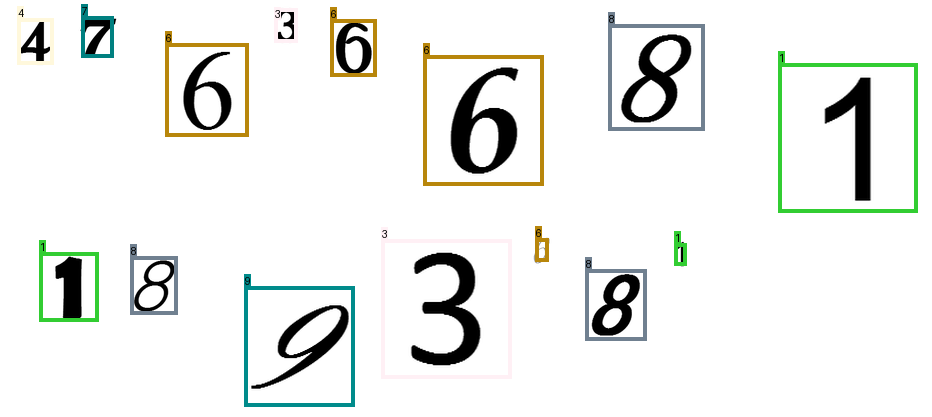



 20 >  cartel_497920038294777.txt
	 - 4 (0.122439, 0.341019, 0.13832, 0.351942) -> 4 (52, 67, 187, 212)
	 - 8 (0.259734, 0.166262, 0.052254, 0.148058) -> 9 (228, 37, 279, 98)
	 - 7 (0.395492, 0.242718, 0.141393, 0.359223) -> 7 (317, 25, 454, 173)
	 - 8 (0.518955, 0.151699, 0.046107, 0.133495) -> 9 (483, 35, 529, 89)
	 - 0 (0.690574, 0.279126, 0.125, 0.320388) -> 2 (613, 48, 735, 180)
	 - 1 (0.817623, 0.165049, 0.04918, 0.140777) -> 0 (774, 39, 821, 97)
	 - 1 (0.932377, 0.174757, 0.104508, 0.271845) -> 0 (859, 15, 960, 127)
	 - 5 (0.07582, 0.718447, 0.077869, 0.208738) -> 3 (36, 253, 112, 339)
	 - 2 (0.184939, 0.70267, 0.052254, 0.148058) -> 8 (155, 259, 206, 319)
	 - 0 (0.287398, 0.717233, 0.052254, 0.148058) -> 2 (255, 265, 306, 325)
	 - 8 (0.372951, 0.706311, 0.07582, 0.203883) -> 9 (327, 249, 401, 333)
	 - 4 (0.57377, 0.800971, 0.137295, 0.349515) -> 4 (492, 257, 626, 402)
	 - 7 (0.76793, 0.79733, 0.119877, 0.308252) -> 7 (690, 265, 807, 391)
	 - 7 (0.873975, 0.691748, 0.038934, 0

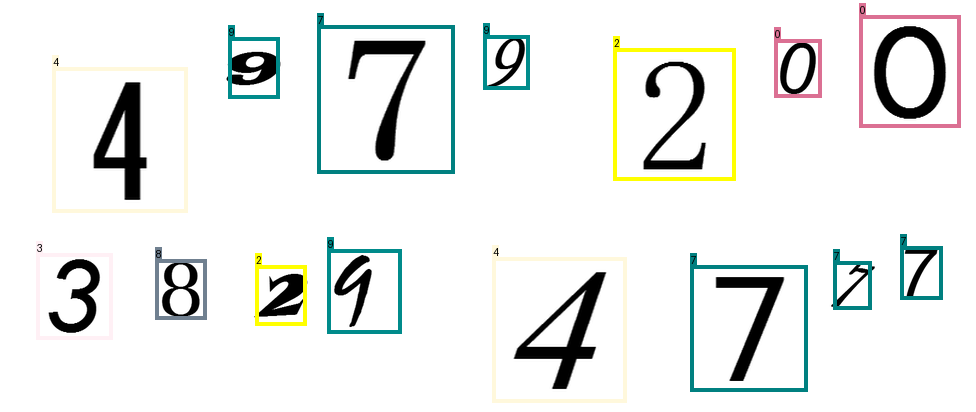



 21 >  cartel_750998277921455.txt
	 - 7 (0.026134, 0.112613, 0.026627, 0.111111) -> 7 (12, 19, 39, 56)
	 - 9 (0.108481, 0.204204, 0.04931, 0.18018) -> 5 (84, 37, 134, 97)
	 - 1 (0.25789, 0.325826, 0.101578, 0.339339) -> 0 (210, 52, 313, 165)
	 - 8 (0.395957, 0.175676, 0.068047, 0.237237) -> 9 (367, 19, 436, 98)
	 - 8 (0.475838, 0.103604, 0.040434, 0.153153) -> 9 (461, 9, 502, 60)
	 - 2 (0.575444, 0.298799, 0.081854, 0.279279) -> 8 (542, 53, 625, 146)
	 - 0 (0.691321, 0.24024, 0.063116, 0.222222) -> 2 (668, 42, 732, 116)
	 - 7 (0.787968, 0.294294, 0.084813, 0.288288) -> 7 (755, 49, 841, 145)
	 - 7 (0.933925, 0.213213, 0.102564, 0.342342) -> 7 (895, 13, 998, 127)
	 - 8 (0.043886, 0.626126, 0.050296, 0.183183) -> 9 (19, 177, 70, 238)
	 - 0 (0.127219, 0.654655, 0.035503, 0.138138) -> 2 (111, 195, 147, 241)
	 - 6 (0.195759, 0.677177, 0.038462, 0.147147) -> 1 (178, 200, 217, 249)
	 - 4 (0.319527, 0.738739, 0.09073, 0.306306) -> 4 (278, 195, 370, 297)
	 - 9 (0.466963, 0.8003, 0.101578, 0.33

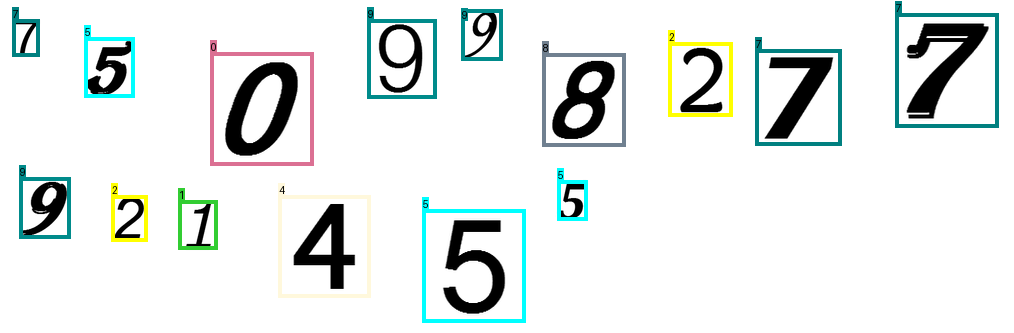



 22 >  cartel_780856375070546.txt
	 - 7 (0.039382, 0.154655, 0.032901, 0.129129) -> 7 (23, 30, 55, 73)
	 - 2 (0.157527, 0.246246, 0.097707, 0.324324) -> 8 (108, 27, 206, 135)
	 - 1 (0.301595, 0.208709, 0.07677, 0.261261) -> 0 (263, 26, 340, 113)
	 - 2 (0.401296, 0.190691, 0.054835, 0.195195) -> 8 (375, 31, 429, 96)
	 - 9 (0.516451, 0.279279, 0.131605, 0.426426) -> 5 (452, 21, 584, 163)
	 - 3 (0.682453, 0.283784, 0.082752, 0.279279) -> 6 (643, 48, 726, 141)
	 - 5 (0.769691, 0.102102, 0.037886, 0.144144) -> 3 (753, 9, 790, 57)
	 - 7 (0.827517, 0.105105, 0.015952, 0.078078) -> 7 (821, 21, 837, 47)
	 - 9 (0.886341, 0.195195, 0.04985, 0.18018) -> 5 (864, 34, 913, 94)
	 - 1 (0.969591, 0.133634, 0.030907, 0.123123) -> 0 (956, 24, 987, 65)
	 - 7 (0.117149, 0.797297, 0.104686, 0.345345) -> 7 (65, 207, 170, 322)
	 - 1 (0.211366, 0.597598, 0.015952, 0.078078) -> 0 (204, 186, 220, 212)
	 - 9 (0.272682, 0.704204, 0.05683, 0.201201) -> 5 (244, 200, 302, 267)
	 - 4 (0.378863, 0.660661, 0.051844, 0.

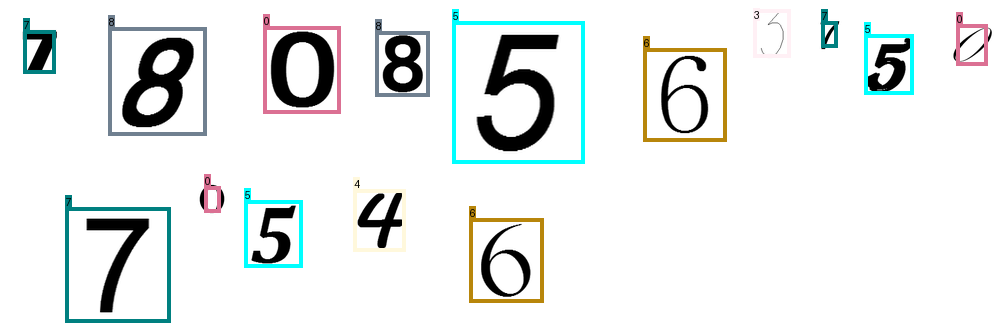



 23 >  cartel_983909907577518.txt
	 - 8 (0.02027, 0.084767, 0.017672, 0.066339) -> 9 (10, 21, 27, 48)
	 - 2 (0.135135, 0.216216, 0.087318, 0.230958) -> 8 (87, 40, 171, 134)
	 - 5 (0.245842, 0.079853, 0.04262, 0.125307) -> 3 (215, 7, 257, 58)
	 - 8 (0.345634, 0.143735, 0.069647, 0.189189) -> 9 (298, 20, 366, 97)
	 - 1 (0.41632, 0.070025, 0.019751, 0.071253) -> 0 (390, 14, 410, 43)
	 - 8 (0.45842, 0.095823, 0.02079, 0.07371) -> 9 (431, 23, 451, 53)
	 - 8 (0.610707, 0.296069, 0.129938, 0.331695) -> 9 (524, 53, 650, 188)
	 - 1 (0.766112, 0.17199, 0.06237, 0.17199) -> 0 (706, 34, 766, 104)
	 - 7 (0.917879, 0.211302, 0.133056, 0.339066) -> 7 (818, 16, 946, 154)
	 - 9 (0.054054, 0.633907, 0.064449, 0.176904) -> 5 (20, 222, 82, 294)
	 - 7 (0.245842, 0.748157, 0.140333, 0.356265) -> 7 (168, 231, 304, 376)
	 - 7 (0.373701, 0.608108, 0.030146, 0.095823) -> 7 (345, 227, 374, 266)
	 - 9 (0.549376, 0.79484, 0.142412, 0.361179) -> 5 (459, 249, 596, 396)
	 - 6 (0.739605, 0.625307, 0.088358, 0.233415

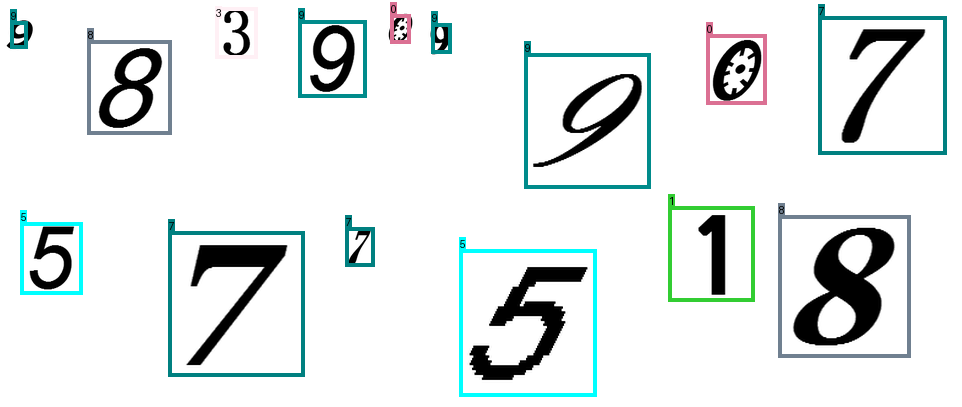



 24 >  cartel_606804027282103.txt
	 - 3 (0.043323, 0.246177, 0.06422, 0.223242) -> 6 (10, 43, 73, 116)
	 - 1 (0.126402, 0.079511, 0.028542, 0.116208) -> 0 (110, 7, 138, 45)
	 - 3 (0.189602, 0.116208, 0.053007, 0.189602) -> 6 (159, 7, 211, 68)
	 - 2 (0.272681, 0.133028, 0.033639, 0.131498) -> 8 (251, 22, 283, 65)
	 - 1 (0.357288, 0.148318, 0.049949, 0.180428) -> 0 (325, 19, 374, 77)
	 - 4 (0.482161, 0.308869, 0.087666, 0.293578) -> 4 (429, 53, 516, 149)
	 - 1 (0.565749, 0.076453, 0.022426, 0.097859) -> 0 (543, 9, 565, 41)
	 - 0 (0.680938, 0.214067, 0.081549, 0.275229) -> 2 (628, 24, 707, 114)
	 - 7 (0.804281, 0.186544, 0.083588, 0.281346) -> 7 (747, 14, 829, 106)
	 - 0 (0.937819, 0.302752, 0.093782, 0.311927) -> 2 (874, 47, 966, 149)
	 - 2 (0.090214, 0.735474, 0.121305, 0.394495) -> 8 (28, 176, 148, 304)
	 - 0 (0.271662, 0.811927, 0.094801, 0.314985) -> 2 (220, 214, 313, 317)
	 - 6 (0.385831, 0.689602, 0.056065, 0.198777) -> 1 (351, 192, 406, 257)
	 - 1 (0.469419, 0.62844, 0.035678, 0

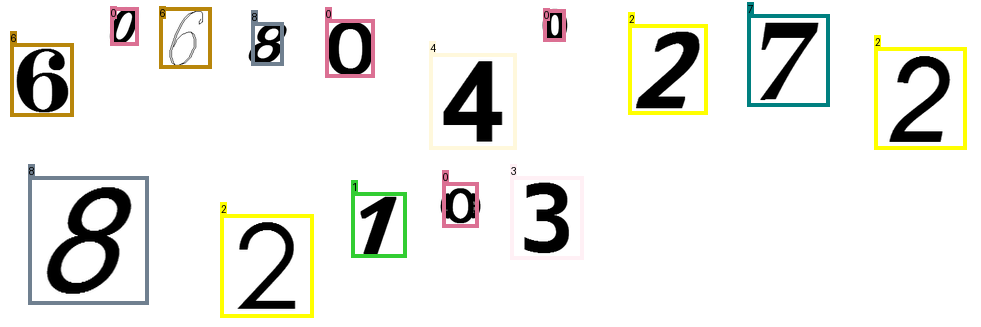



 25 >  cartel_112007276393085.txt
	 - 6 (0.045109, 0.135569, 0.03587, 0.125364) -> 1 (25, 25, 58, 68)
	 - 6 (0.138587, 0.185131, 0.055435, 0.177843) -> 1 (101, 32, 153, 94)
	 - 0 (0.255978, 0.252187, 0.08587, 0.259475) -> 2 (195, 42, 274, 131)
	 - 1 (0.3875, 0.164723, 0.092391, 0.276968) -> 0 (314, 8, 398, 104)
	 - 1 (0.483696, 0.104956, 0.021739, 0.087464) -> 0 (435, 20, 455, 50)
	 - 7 (0.531522, 0.072886, 0.015217, 0.069971) -> 7 (482, 12, 496, 36)
	 - 0 (0.636413, 0.249271, 0.072826, 0.22449) -> 2 (552, 46, 618, 123)
	 - 7 (0.759783, 0.206997, 0.082609, 0.250729) -> 7 (661, 27, 737, 113)
	 - 3 (0.933696, 0.294461, 0.1, 0.297376) -> 6 (813, 50, 905, 152)
	 - 5 (0.066304, 0.685131, 0.093478, 0.279883) -> 3 (17, 186, 103, 282)
	 - 8 (0.2125, 0.674927, 0.090217, 0.271137) -> 9 (154, 184, 236, 277)
	 - 5 (0.317391, 0.597668, 0.043478, 0.145773) -> 3 (271, 180, 311, 230)
	 - 1 (0.417391, 0.763848, 0.102174, 0.303207) -> 0 (336, 209, 430, 313)
	 - 2 (0.558152, 0.779883, 0.131522, 0.38192

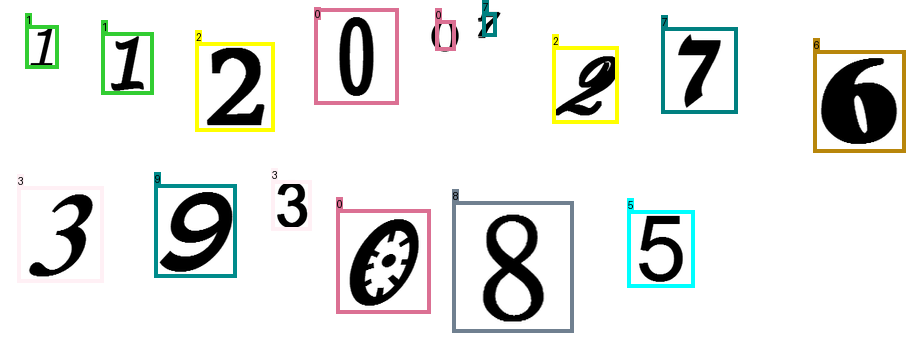



 26 >  cartel_140000197285897.txt
	 - 6 (0.083744, 0.169811, 0.102463, 0.268868) -> 1 (33, 14, 137, 128)
	 - 4 (0.172414, 0.068396, 0.033498, 0.103774) -> 4 (157, 6, 192, 50)
	 - 1 (0.237931, 0.086085, 0.028571, 0.091981) -> 0 (227, 17, 255, 56)
	 - 1 (0.335468, 0.206368, 0.083744, 0.224057) -> 0 (297, 39, 383, 135)
	 - 1 (0.49803, 0.204009, 0.11133, 0.290094) -> 0 (449, 24, 562, 147)
	 - 1 (0.592118, 0.058962, 0.021675, 0.075472) -> 0 (589, 8, 611, 40)
	 - 6 (0.696552, 0.313679, 0.112315, 0.292453) -> 1 (650, 70, 764, 194)
	 - 8 (0.814778, 0.200472, 0.070936, 0.193396) -> 9 (790, 44, 862, 126)
	 - 7 (0.940394, 0.147406, 0.089655, 0.238208) -> 7 (908, 12, 999, 113)
	 - 0 (0.02266, 0.549528, 0.015764, 0.061321) -> 2 (14, 219, 31, 245)
	 - 2 (0.090148, 0.557783, 0.030542, 0.096698) -> 8 (76, 216, 107, 256)
	 - 9 (0.196059, 0.721698, 0.0867, 0.231132) -> 5 (154, 256, 243, 354)
	 - 2 (0.343842, 0.629717, 0.078818, 0.212264) -> 8 (308, 222, 388, 311)
	 - 8 (0.460099, 0.587264, 0.063054, 0

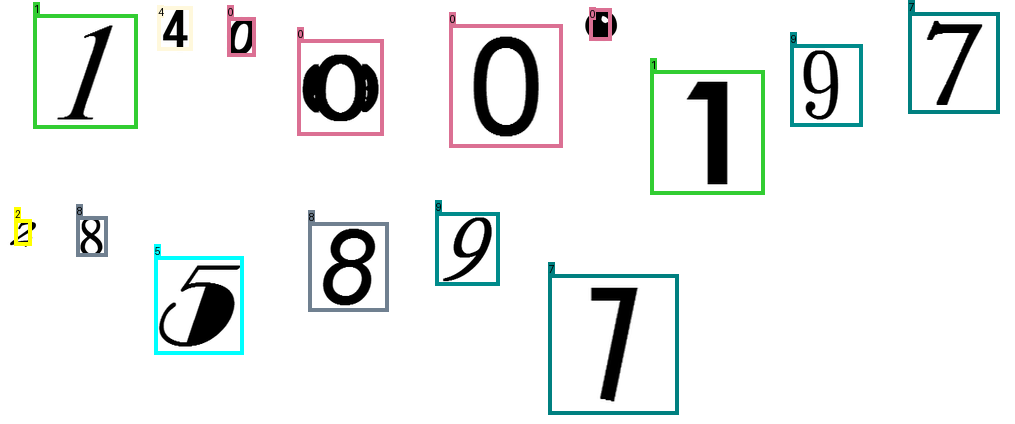



 27 >  cartel_271553805877002.txt
	 - 0 (0.112164, 0.315385, 0.10668, 0.36) -> 2 (59, 44, 166, 161)
	 - 7 (0.219342, 0.107692, 0.035892, 0.141538) -> 7 (202, 11, 237, 57)
	 - 6 (0.358425, 0.312308, 0.120638, 0.403077) -> 1 (299, 36, 420, 167)
	 - 9 (0.500997, 0.14, 0.060818, 0.218462) -> 5 (471, 9, 533, 81)
	 - 9 (0.570289, 0.126154, 0.023928, 0.104615) -> 5 (559, 24, 583, 57)
	 - 5 (0.62014, 0.129231, 0.02991, 0.123077) -> 3 (607, 22, 637, 62)
	 - 2 (0.707378, 0.241538, 0.062812, 0.224615) -> 8 (677, 41, 741, 114)
	 - 1 (0.805583, 0.141538, 0.055833, 0.203077) -> 0 (779, 12, 835, 78)
	 - 9 (0.92323, 0.286154, 0.123629, 0.412308) -> 5 (863, 26, 987, 160)
	 - 2 (0.078764, 0.710769, 0.067797, 0.24) -> 8 (45, 191, 113, 269)
	 - 7 (0.212363, 0.809231, 0.093719, 0.32) -> 7 (166, 211, 260, 315)
	 - 7 (0.29661, 0.644615, 0.024925, 0.107692) -> 7 (284, 191, 309, 226)
	 - 1 (0.389831, 0.723077, 0.085743, 0.295385) -> 0 (348, 186, 434, 283)
	 - 1 (0.521934, 0.712308, 0.07677, 0.267692) -> 0 (4

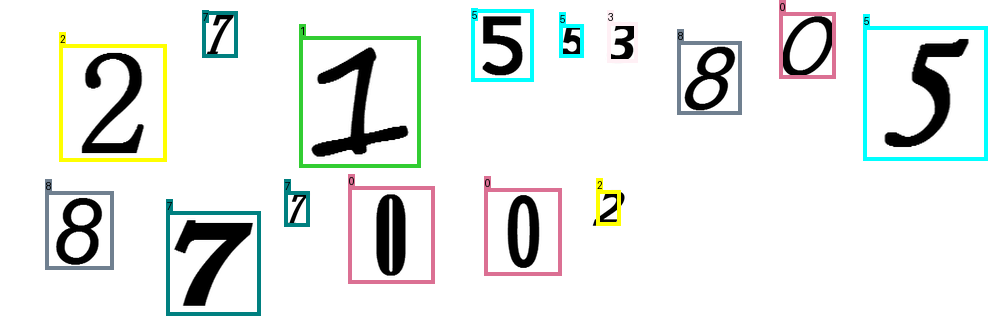



 28 >  cartel_086801031844537.txt
	 - 1 (0.102827, 0.14678, 0.098441, 0.210227) -> 0 (55, 21, 156, 132)
	 - 2 (0.236842, 0.107955, 0.087719, 0.189394) -> 8 (198, 7, 287, 107)
	 - 3 (0.360624, 0.098485, 0.066277, 0.147727) -> 6 (336, 13, 404, 91)
	 - 2 (0.465887, 0.079545, 0.042885, 0.102273) -> 8 (456, 14, 500, 68)
	 - 1 (0.580897, 0.096591, 0.074074, 0.162879) -> 0 (558, 7, 634, 94)
	 - 6 (0.696394, 0.133523, 0.059454, 0.13447) -> 1 (684, 35, 745, 106)
	 - 1 (0.806043, 0.159091, 0.105263, 0.223485) -> 0 (773, 25, 881, 143)
	 - 5 (0.132554, 0.486742, 0.11501, 0.242424) -> 3 (77, 192, 195, 320)
	 - 6 (0.290448, 0.496212, 0.107212, 0.227273) -> 1 (242, 201, 352, 322)
	 - 2 (0.423489, 0.493371, 0.104288, 0.221591) -> 8 (380, 201, 487, 318)
	 - 4 (0.546296, 0.476326, 0.069201, 0.153409) -> 4 (524, 211, 595, 292)
	 - 4 (0.73538, 0.586174, 0.133528, 0.278409) -> 4 (686, 235, 822, 382)
	 - 9 (0.923489, 0.553977, 0.123782, 0.25947) -> 5 (883, 223, 1010, 360)
	 - 5 (0.041423, 0.79072, 0.02436

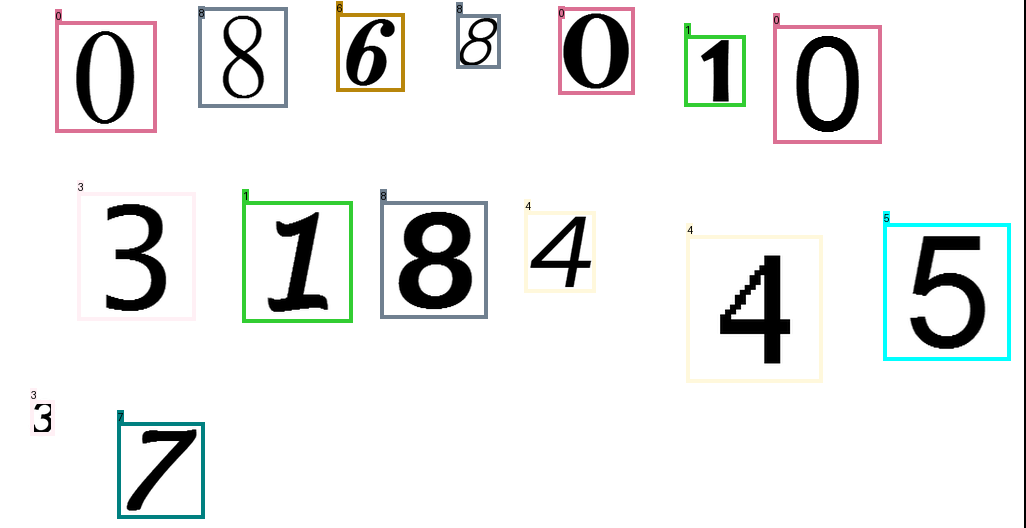



 29 >  cartel_369072629599043.txt
	 - 5 (0.091331, 0.203504, 0.104231, 0.299191) -> 3 (37, 20, 138, 130)
	 - 3 (0.178019, 0.074124, 0.013416, 0.061995) -> 6 (166, 15, 179, 39)
	 - 8 (0.26935, 0.121294, 0.055728, 0.172507) -> 9 (233, 13, 288, 77)
	 - 1 (0.359649, 0.17655, 0.067079, 0.202156) -> 0 (316, 28, 380, 102)
	 - 7 (0.46646, 0.121294, 0.063983, 0.19407) -> 7 (420, 9, 482, 81)
	 - 0 (0.627967, 0.33558, 0.133127, 0.374663) -> 2 (543, 55, 673, 194)
	 - 3 (0.799794, 0.28841, 0.092879, 0.269542) -> 6 (730, 57, 820, 157)
	 - 0 (0.920021, 0.092992, 0.04644, 0.148248) -> 2 (869, 7, 914, 62)
	 - 8 (0.975232, 0.059299, 0.018576, 0.075472) -> 9 (935, 7, 953, 35)
	 - 9 (0.081011, 0.783019, 0.135191, 0.380054) -> 5 (12, 220, 143, 361)
	 - 8 (0.190918, 0.601078, 0.014448, 0.06469) -> 9 (177, 210, 191, 234)
	 - 8 (0.234778, 0.621294, 0.01548, 0.067385) -> 9 (219, 218, 234, 242)
	 - 1 (0.342621, 0.722372, 0.101135, 0.291105) -> 0 (282, 214, 380, 321)
	 - 4 (0.47936, 0.734501, 0.079463, 0.23450

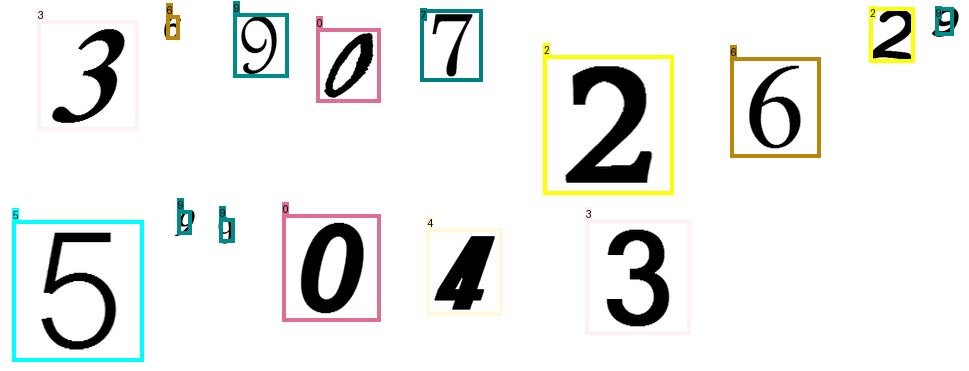



 30 >  cartel_798639498228005.txt
	 - 7 (0.047391, 0.07958, 0.030884, 0.117117) -> 7 (30, 7, 59, 46)
	 - 8 (0.133653, 0.154655, 0.054313, 0.183183) -> 9 (100, 21, 151, 82)
	 - 2 (0.230032, 0.153153, 0.048988, 0.168168) -> 8 (193, 22, 238, 78)
	 - 3 (0.382854, 0.250751, 0.103301, 0.321321) -> 6 (311, 30, 407, 137)
	 - 5 (0.525559, 0.238739, 0.103301, 0.321321) -> 3 (445, 26, 541, 133)
	 - 8 (0.619276, 0.106607, 0.024494, 0.099099) -> 9 (570, 19, 593, 52)
	 - 4 (0.761981, 0.223724, 0.120341, 0.369369) -> 4 (659, 13, 772, 136)
	 - 8 (0.93983, 0.190691, 0.088392, 0.279279) -> 9 (841, 17, 924, 110)
	 - 2 (0.044196, 0.587087, 0.052183, 0.177177) -> 8 (17, 166, 65, 224)
	 - 0 (0.171459, 0.717718, 0.110756, 0.342342) -> 2 (109, 182, 212, 296)
	 - 0 (0.263578, 0.563063, 0.028754, 0.111111) -> 2 (233, 168, 260, 205)
	 - 2 (0.391374, 0.749249, 0.1459, 0.441441) -> 8 (299, 175, 436, 322)
	 - 1 (0.57295, 0.711712, 0.132055, 0.402402) -> 0 (476, 170, 599, 304)
	 - 1 (0.746539, 0.711712, 0.144835, 

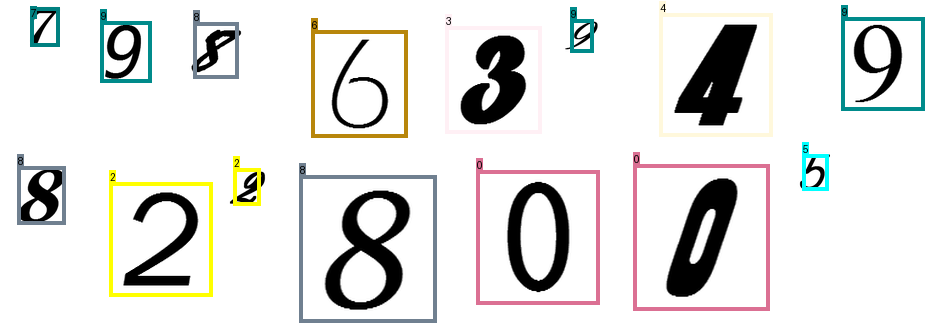



 31 >  cartel_905026538643775.txt
	 - 8 (0.050276, 0.141667, 0.054144, 0.196667) -> 9 (20, 13, 69, 72)
	 - 1 (0.144199, 0.161667, 0.076243, 0.263333) -> 0 (96, 9, 165, 88)
	 - 9 (0.217127, 0.068333, 0.014365, 0.076667) -> 5 (189, 8, 203, 31)
	 - 1 (0.338122, 0.326667, 0.123757, 0.406667) -> 0 (250, 37, 362, 159)
	 - 0 (0.48011, 0.221667, 0.062983, 0.223333) -> 2 (405, 33, 462, 100)
	 - 3 (0.564088, 0.135, 0.029834, 0.123333) -> 6 (496, 22, 523, 58)
	 - 9 (0.652486, 0.195, 0.051934, 0.19) -> 5 (566, 30, 613, 87)
	 - 5 (0.78453, 0.25, 0.077348, 0.266667) -> 3 (674, 34, 744, 115)
	 - 2 (0.925967, 0.323333, 0.114917, 0.38) -> 8 (786, 39, 890, 153)
	 - 3 (0.076243, 0.756667, 0.083978, 0.286667) -> 6 (30, 184, 106, 270)
	 - 4 (0.181215, 0.72, 0.061878, 0.22) -> 4 (135, 183, 191, 249)
	 - 5 (0.303315, 0.725, 0.060773, 0.216667) -> 3 (247, 184, 301, 250)
	 - 7 (0.41768, 0.84, 0.072928, 0.253333) -> 7 (345, 214, 411, 289)
	 - 7 (0.493923, 0.703333, 0.030939, 0.126667) -> 7 (433, 191, 461, 229

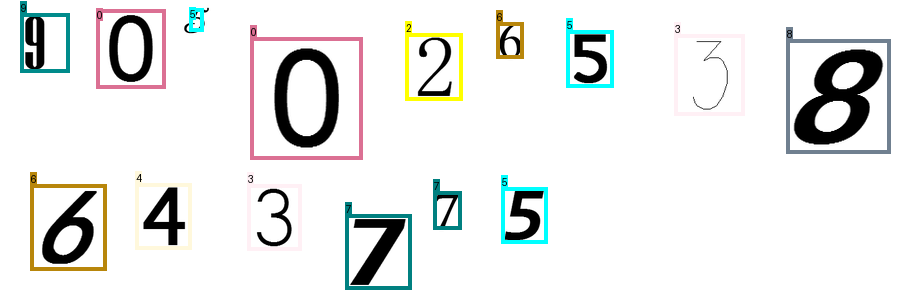



 32 >  cartel_862573286199724.txt
	 - 2 (0.10364, 0.255291, 0.096057, 0.277778) -> 8 (54, 43, 150, 149)
	 - 3 (0.185035, 0.079365, 0.0182, 0.074074) -> 6 (173, 15, 191, 43)
	 - 0 (0.320526, 0.306878, 0.137513, 0.386243) -> 2 (249, 42, 385, 188)
	 - 9 (0.524772, 0.346561, 0.123357, 0.349206) -> 5 (457, 65, 579, 196)
	 - 7 (0.649646, 0.117725, 0.037412, 0.124339) -> 7 (623, 20, 661, 68)
	 - 5 (0.748231, 0.153439, 0.060667, 0.185185) -> 3 (710, 22, 770, 92)
	 - 0 (0.915571, 0.398148, 0.138524, 0.388889) -> 2 (836, 76, 973, 223)
	 - 2 (0.087968, 0.804233, 0.095046, 0.275132) -> 8 (40, 252, 134, 356)
	 - 3 (0.206775, 0.763228, 0.081901, 0.240741) -> 6 (164, 243, 245, 334)
	 - 6 (0.284125, 0.714286, 0.024267, 0.089947) -> 1 (268, 253, 292, 287)
	 - 8 (0.40546, 0.796296, 0.08089, 0.238095) -> 9 (360, 255, 441, 345)
	 - 8 (0.523256, 0.800265, 0.059656, 0.18254) -> 9 (488, 268, 547, 337)
	 - 7 (0.596057, 0.691799, 0.029323, 0.103175) -> 7 (575, 241, 604, 281)
	 - 0 (0.660263, 0.695767, 0.0303

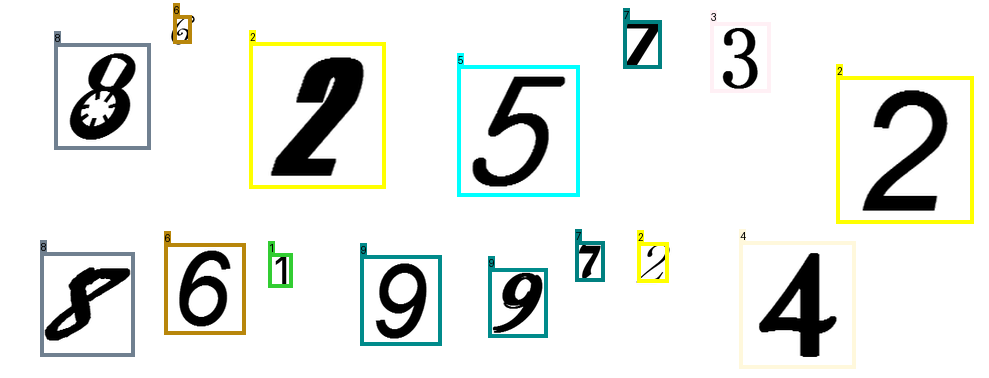



 33 >  cartel_242720340991864.txt
	 - 0 (0.08871, 0.168182, 0.074597, 0.190909) -> 2 (51, 32, 125, 116)
	 - 4 (0.162802, 0.046591, 0.019153, 0.065909) -> 4 (151, 6, 170, 35)
	 - 0 (0.229839, 0.143182, 0.044355, 0.122727) -> 2 (206, 36, 250, 90)
	 - 7 (0.327117, 0.217045, 0.083669, 0.211364) -> 7 (283, 48, 365, 141)
	 - 0 (0.487903, 0.181818, 0.112903, 0.277273) -> 2 (427, 18, 539, 140)
	 - 1 (0.633569, 0.201136, 0.13004, 0.315909) -> 0 (564, 18, 693, 157)
	 - 5 (0.795867, 0.289773, 0.132056, 0.320455) -> 3 (724, 57, 854, 198)
	 - 4 (0.117944, 0.806818, 0.135081, 0.327273) -> 4 (50, 282, 184, 426)
	 - 1 (0.22127, 0.576136, 0.027218, 0.084091) -> 0 (205, 234, 232, 271)
	 - 8 (0.322077, 0.789773, 0.132056, 0.320455) -> 9 (254, 277, 385, 418)
	 - 8 (0.438508, 0.643182, 0.050403, 0.136364) -> 9 (410, 253, 459, 313)
	 - 6 (0.50504, 0.586364, 0.022177, 0.072727) -> 1 (489, 242, 511, 274)
	 - 2 (0.628528, 0.807955, 0.140121, 0.338636) -> 8 (553, 281, 692, 430)
	 - 3 (0.803931, 0.7125, 0.1078

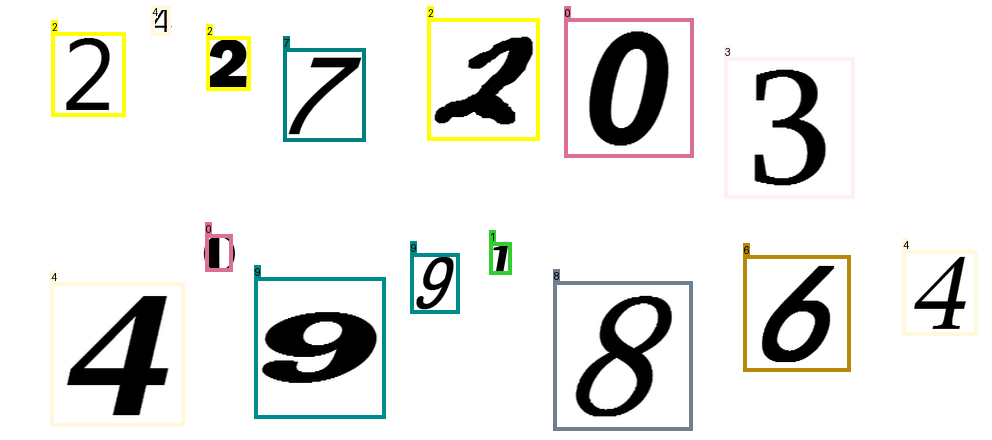



 34 >  cartel_030468687869786.txt
	 - 1 (0.025237, 0.067024, 0.012618, 0.058981) -> 0 (18, 13, 30, 35)
	 - 5 (0.115668, 0.184987, 0.090431, 0.257373) -> 3 (67, 21, 153, 117)
	 - 1 (0.218717, 0.174263, 0.04837, 0.150134) -> 0 (184, 37, 230, 93)
	 - 4 (0.299685, 0.219839, 0.067298, 0.198391) -> 4 (253, 45, 317, 118)
	 - 3 (0.422713, 0.198391, 0.105152, 0.294906) -> 6 (352, 18, 451, 128)
	 - 2 (0.547319, 0.183646, 0.055731, 0.168901) -> 8 (494, 36, 547, 99)
	 - 3 (0.715563, 0.258713, 0.116719, 0.324397) -> 6 (625, 35, 736, 156)
	 - 2 (0.917455, 0.269437, 0.133544, 0.367292) -> 8 (808, 32, 935, 168)
	 - 7 (0.04837, 0.587131, 0.060988, 0.182306) -> 7 (17, 184, 74, 252)
	 - 2 (0.201893, 0.80429, 0.121977, 0.337802) -> 8 (134, 237, 250, 363)
	 - 3 (0.364879, 0.670241, 0.100946, 0.284182) -> 6 (299, 196, 394, 302)
	 - 8 (0.5, 0.693029, 0.104101, 0.292225) -> 9 (425, 203, 525, 312)
	 - 7 (0.594637, 0.593834, 0.030494, 0.104558) -> 7 (550, 202, 579, 241)
	 - 2 (0.715037, 0.656836, 0.073607, 0.

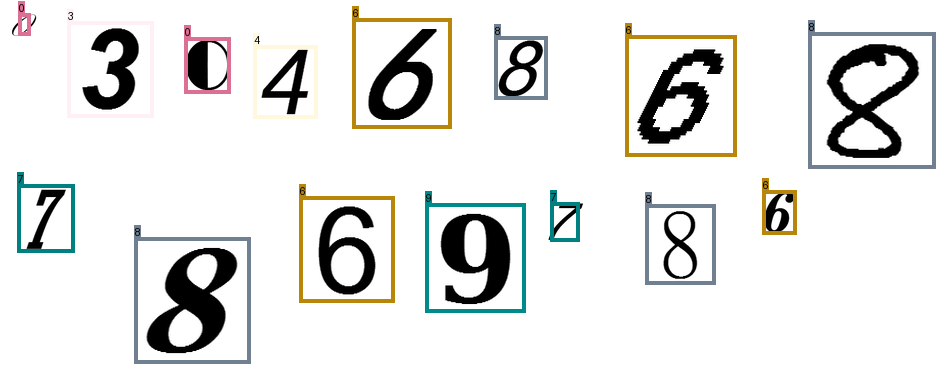



 35 >  cartel_972189396816215.txt
	 - 8 (0.089598, 0.348442, 0.123584, 0.368272) -> 9 (26, 58, 146, 188)
	 - 7 (0.217302, 0.155807, 0.057673, 0.186969) -> 7 (183, 21, 239, 87)
	 - 0 (0.339856, 0.130312, 0.063852, 0.203966) -> 2 (299, 10, 361, 82)
	 - 6 (0.435118, 0.094901, 0.033986, 0.121813) -> 1 (405, 12, 438, 55)
	 - 2 (0.512873, 0.133144, 0.057673, 0.186969) -> 8 (469, 13, 525, 79)
	 - 8 (0.590113, 0.104816, 0.018538, 0.07932) -> 9 (563, 23, 581, 51)
	 - 5 (0.703913, 0.338527, 0.104016, 0.314448) -> 3 (632, 63, 733, 175)
	 - 8 (0.891864, 0.23796, 0.107106, 0.322946) -> 9 (813, 26, 917, 140)
	 - 3 (0.977858, 0.063739, 0.013388, 0.065156) -> 6 (943, 10, 955, 33)
	 - 2 (0.077755, 0.771955, 0.091658, 0.280453) -> 8 (31, 223, 120, 322)
	 - 6 (0.168898, 0.66289, 0.039135, 0.135977) -> 1 (144, 210, 183, 258)
	 - 3 (0.218332, 0.66289, 0.016478, 0.073654) -> 6 (204, 221, 220, 247)
	 - 0 (0.331102, 0.803116, 0.112255, 0.33711) -> 2 (267, 224, 375, 342)
	 - 6 (0.444387, 0.715297, 0.046344, 

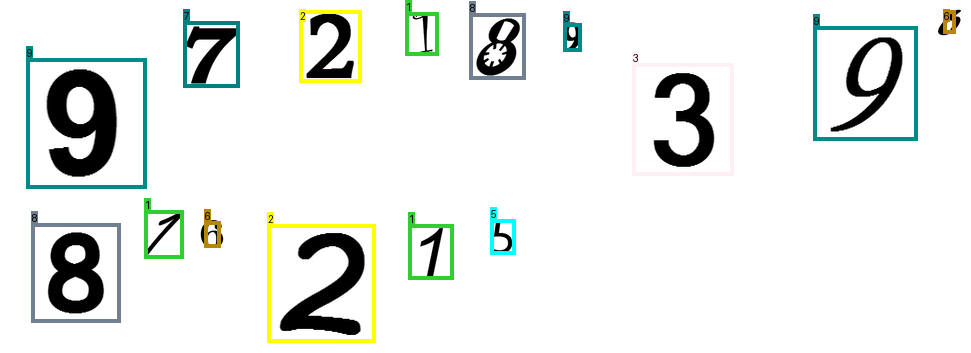



 36 >  cartel_873317568517667.txt
	 - 2 (0.058708, 0.137931, 0.052838, 0.183908) -> 8 (32, 15, 86, 79)
	 - 7 (0.17319, 0.350575, 0.111546, 0.356322) -> 7 (120, 60, 234, 184)
	 - 5 (0.318493, 0.260057, 0.073386, 0.244253) -> 3 (287, 47, 363, 132)
	 - 5 (0.398239, 0.08046, 0.015656, 0.074713) -> 3 (399, 15, 415, 41)
	 - 6 (0.464775, 0.123563, 0.035225, 0.132184) -> 1 (457, 19, 493, 65)
	 - 7 (0.574364, 0.198276, 0.082192, 0.270115) -> 7 (544, 22, 629, 116)
	 - 9 (0.716732, 0.216954, 0.106654, 0.341954) -> 5 (677, 15, 787, 134)
	 - 3 (0.918297, 0.234195, 0.134051, 0.422414) -> 6 (869, 7, 1006, 154)
	 - 2 (0.05773, 0.706897, 0.043053, 0.155172) -> 8 (36, 219, 81, 273)
	 - 9 (0.152153, 0.722701, 0.061644, 0.20977) -> 5 (124, 214, 187, 287)
	 - 6 (0.323875, 0.778736, 0.113503, 0.362069) -> 1 (273, 208, 389, 334)
	 - 7 (0.413405, 0.630747, 0.016634, 0.077586) -> 7 (413, 205, 430, 232)
	 - 3 (0.53865, 0.788793, 0.114481, 0.364943) -> 6 (492, 210, 609, 338)
	 - 3 (0.642857, 0.689655, 0.041096

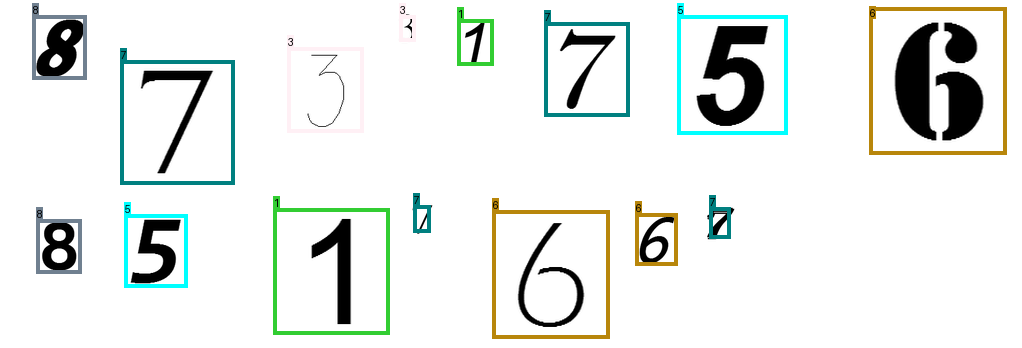



 37 >  cartel_357179173128348.txt
	 - 5 (0.047404, 0.123288, 0.027088, 0.116438) -> 3 (29, 19, 53, 53)
	 - 9 (0.12754, 0.246575, 0.079007, 0.273973) -> 5 (78, 31, 148, 111)
	 - 7 (0.221783, 0.128425, 0.023702, 0.106164) -> 7 (185, 22, 206, 53)
	 - 6 (0.382054, 0.32363, 0.11851, 0.393836) -> 1 (285, 36, 390, 152)
	 - 7 (0.538939, 0.27911, 0.08465, 0.291096) -> 7 (440, 39, 514, 124)
	 - 8 (0.685666, 0.217466, 0.073363, 0.256849) -> 9 (575, 26, 639, 101)
	 - 6 (0.804176, 0.169521, 0.048533, 0.181507) -> 1 (690, 23, 734, 76)
	 - 7 (0.865688, 0.123288, 0.018059, 0.089041) -> 7 (758, 23, 774, 49)
	 - 5 (0.95316, 0.159247, 0.059819, 0.215753) -> 3 (817, 15, 870, 78)
	 - 6 (0.081828, 0.785959, 0.107223, 0.359589) -> 1 (24, 177, 119, 282)
	 - 0 (0.227991, 0.763699, 0.106095, 0.356164) -> 2 (154, 171, 249, 275)
	 - 2 (0.371332, 0.791096, 0.092551, 0.315068) -> 8 (288, 185, 370, 276)
	 - 5 (0.475169, 0.732877, 0.060948, 0.219178) -> 3 (393, 182, 447, 246)
	 - 4 (0.558126, 0.635274, 0.025959, 0.

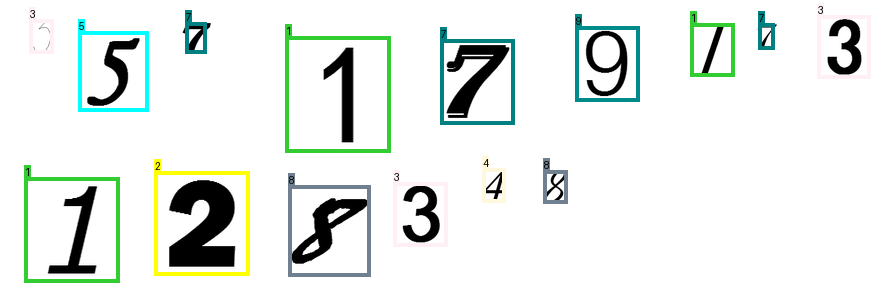



 38 >  cartel_855084833788226.txt
	 - 2 (0.100098, 0.222646, 0.112305, 0.318066) -> 8 (45, 24, 160, 149)
	 - 9 (0.201172, 0.111959, 0.03125, 0.10687) -> 5 (190, 22, 222, 64)
	 - 9 (0.268066, 0.131043, 0.05957, 0.180662) -> 5 (243, 15, 304, 86)
	 - 1 (0.380859, 0.211196, 0.113281, 0.320611) -> 0 (331, 19, 447, 146)
	 - 2 (0.554688, 0.335878, 0.109375, 0.310433) -> 8 (512, 70, 624, 193)
	 - 4 (0.683105, 0.253181, 0.094727, 0.272265) -> 4 (650, 46, 747, 153)
	 - 2 (0.778809, 0.128499, 0.051758, 0.160305) -> 8 (771, 19, 824, 82)
	 - 5 (0.928223, 0.235369, 0.114258, 0.323155) -> 3 (892, 29, 1009, 155)
	 - 5 (0.03418, 0.580153, 0.021484, 0.081425) -> 3 (24, 212, 46, 244)
	 - 7 (0.089355, 0.581425, 0.022461, 0.083969) -> 7 (79, 212, 102, 244)
	 - 2 (0.213379, 0.823155, 0.106445, 0.302799) -> 8 (164, 263, 272, 382)
	 - 2 (0.336426, 0.637405, 0.047852, 0.150127) -> 8 (320, 221, 369, 280)
	 - 0 (0.448242, 0.717557, 0.074219, 0.21883) -> 2 (420, 238, 496, 324)
	 - 0 (0.586914, 0.755725, 0.07421

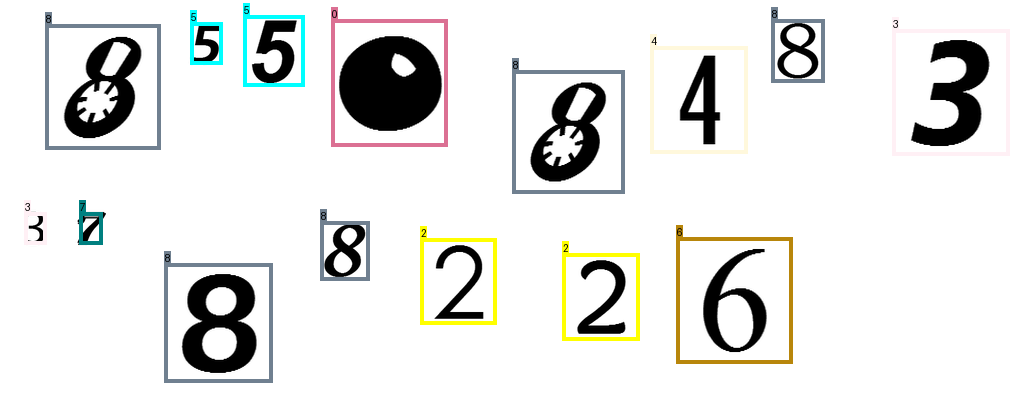



 39 >  cartel_414907293998436.txt
	 - 4 (0.132885, 0.225728, 0.137539, 0.231392) -> 4 (61, 67, 194, 211)
	 - 6 (0.31696, 0.17233, 0.106515, 0.182848) -> 1 (255, 49, 358, 162)
	 - 4 (0.477249, 0.232201, 0.129266, 0.218447) -> 4 (398, 76, 523, 211)
	 - 8 (0.623061, 0.154531, 0.104447, 0.179612) -> 9 (551, 40, 653, 151)
	 - 1 (0.710962, 0.049353, 0.023785, 0.053398) -> 0 (676, 14, 699, 47)
	 - 7 (0.797828, 0.102751, 0.083764, 0.147249) -> 7 (730, 18, 811, 109)
	 - 0 (0.086867, 0.561489, 0.126163, 0.213592) -> 2 (23, 281, 145, 413)
	 - 8 (0.267839, 0.501618, 0.093071, 0.161812) -> 9 (214, 260, 304, 359)
	 - 5 (0.434333, 0.587379, 0.124095, 0.210356) -> 3 (360, 298, 479, 428)
	 - 8 (0.532058, 0.43932, 0.027921, 0.059871) -> 9 (501, 252, 527, 289)
	 - 8 (0.654602, 0.610032, 0.142709, 0.239482) -> 9 (564, 302, 701, 450)
	 - 2 (0.777663, 0.454693, 0.041365, 0.080906) -> 8 (732, 256, 772, 306)
	 - 4 (0.925543, 0.590615, 0.11789, 0.200647) -> 4 (838, 303, 951, 426)
	 - 5 (0.119442, 0.869741, 0

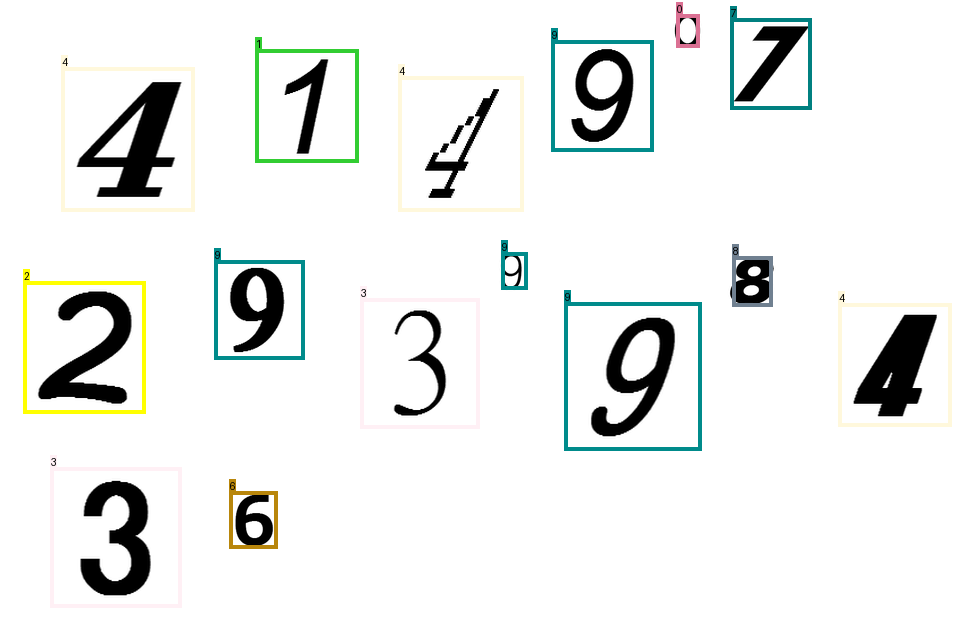



 40 >  cartel_527089729719938.txt
	 - 9 (0.055833, 0.086239, 0.061815, 0.13211) -> 5 (25, 11, 87, 83)
	 - 0 (0.178963, 0.175229, 0.11665, 0.233028) -> 2 (120, 31, 237, 158)
	 - 7 (0.336989, 0.172477, 0.131605, 0.26055) -> 7 (272, 23, 403, 164)
	 - 1 (0.483051, 0.129358, 0.064806, 0.137615) -> 0 (451, 33, 517, 108)
	 - 2 (0.564307, 0.104587, 0.047856, 0.106422) -> 8 (542, 27, 589, 85)
	 - 8 (0.671984, 0.231193, 0.105683, 0.212844) -> 9 (620, 68, 726, 184)
	 - 7 (0.828514, 0.269725, 0.135593, 0.26789) -> 7 (762, 74, 898, 220)
	 - 0 (0.119641, 0.66422, 0.137587, 0.27156) -> 2 (51, 287, 188, 436)
	 - 8 (0.273679, 0.633945, 0.090728, 0.185321) -> 9 (228, 295, 320, 395)
	 - 7 (0.392323, 0.544037, 0.080758, 0.166972) -> 7 (352, 251, 434, 342)
	 - 6 (0.565304, 0.642202, 0.129611, 0.256881) -> 1 (501, 280, 631, 420)
	 - 8 (0.700399, 0.56055, 0.088734, 0.181651) -> 9 (658, 255, 747, 354)
	 - 8 (0.779163, 0.516514, 0.024925, 0.06422) -> 9 (769, 264, 794, 299)
	 - 5 (0.92323, 0.706422, 0.123629,

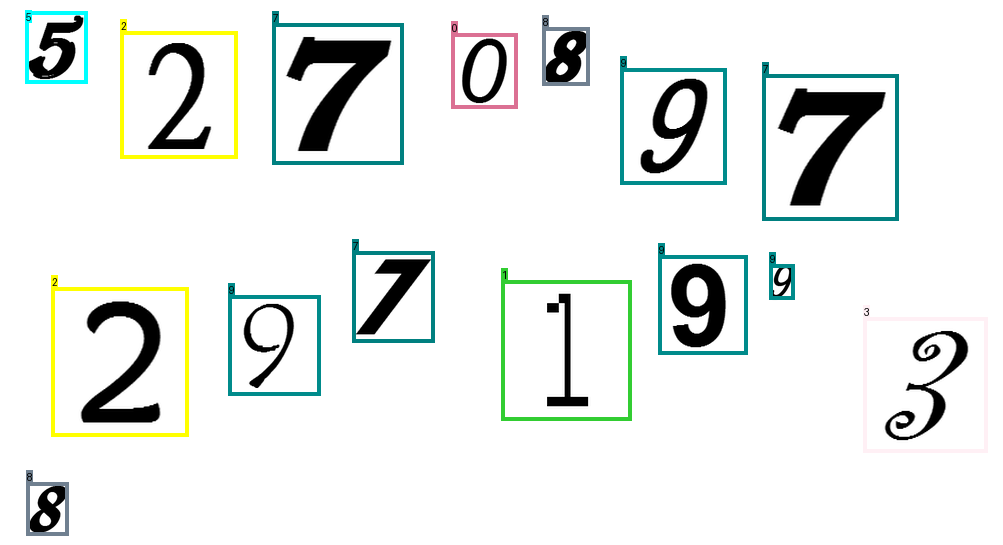



 41 >  cartel_691559176734359.txt
	 - 3 (0.065306, 0.22963, 0.087755, 0.237037) -> 6 (20, 45, 106, 141)
	 - 8 (0.221429, 0.239506, 0.083673, 0.22716) -> 9 (176, 51, 258, 142)
	 - 6 (0.362755, 0.179012, 0.103061, 0.274074) -> 1 (305, 16, 405, 127)
	 - 9 (0.522959, 0.337037, 0.137755, 0.358025) -> 5 (444, 63, 579, 209)
	 - 9 (0.645918, 0.098765, 0.030612, 0.098765) -> 5 (617, 19, 647, 59)
	 - 8 (0.792347, 0.361728, 0.139796, 0.362963) -> 9 (708, 72, 845, 219)
	 - 6 (0.940306, 0.166667, 0.066327, 0.185185) -> 1 (888, 30, 954, 105)
	 - 7 (0.103061, 0.735802, 0.128571, 0.335802) -> 7 (37, 229, 163, 365)
	 - 3 (0.254082, 0.8, 0.091837, 0.246914) -> 6 (204, 273, 294, 374)
	 - 7 (0.380612, 0.812346, 0.089796, 0.241975) -> 7 (328, 280, 416, 378)
	 - 5 (0.5, 0.74321, 0.067347, 0.187654) -> 3 (456, 263, 523, 338)
	 - 4 (0.606122, 0.639506, 0.042857, 0.128395) -> 4 (572, 232, 614, 284)
	 - 5 (0.771429, 0.795062, 0.138776, 0.360494) -> 3 (688, 249, 824, 395)
	 - 9 (0.89898, 0.777778, 0.073469, 0.

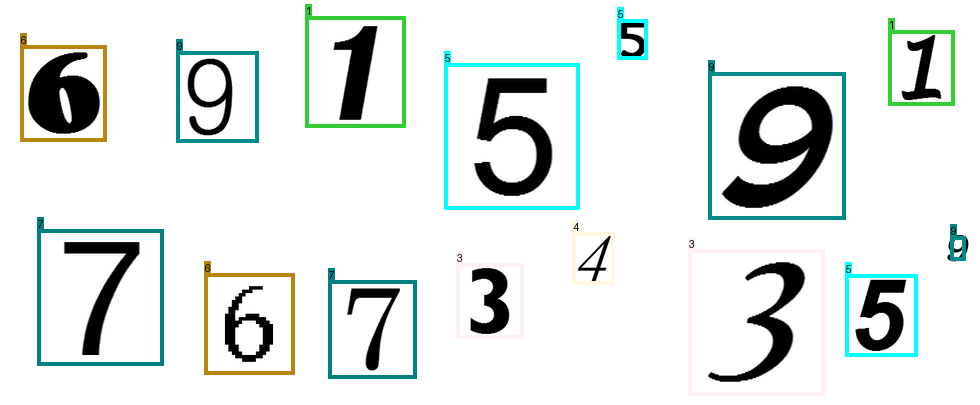



 42 >  cartel_004019053783519.txt
	 - 1 (0.091438, 0.121134, 0.079281, 0.146048) -> 0 (49, 28, 124, 112)
	 - 1 (0.171776, 0.055842, 0.028541, 0.063574) -> 0 (149, 14, 175, 51)
	 - 4 (0.284355, 0.099656, 0.07611, 0.140893) -> 4 (232, 16, 304, 98)
	 - 1 (0.406448, 0.150344, 0.09408, 0.170103) -> 0 (339, 38, 428, 137)
	 - 6 (0.613108, 0.233677, 0.131078, 0.230241) -> 1 (518, 68, 642, 203)
	 - 8 (0.708774, 0.033505, 0.013742, 0.039519) -> 9 (664, 7, 677, 30)
	 - 1 (0.805497, 0.19244, 0.128964, 0.226804) -> 0 (701, 46, 823, 178)
	 - 9 (0.953488, 0.075601, 0.061311, 0.116838) -> 5 (872, 9, 930, 77)
	 - 5 (0.113108, 0.587629, 0.135307, 0.237113) -> 3 (42, 273, 171, 410)
	 - 7 (0.25, 0.457904, 0.049683, 0.097938) -> 7 (212, 238, 260, 295)
	 - 2 (0.364693, 0.515464, 0.078224, 0.14433) -> 8 (307, 258, 381, 342)
	 - 5 (0.575053, 0.621993, 0.141649, 0.247423) -> 3 (477, 289, 611, 434)
	 - 9 (0.787526, 0.54811, 0.124736, 0.219931) -> 5 (685, 255, 803, 382)
	 - 6 (0.939746, 0.517182, 0.080338, 0.1

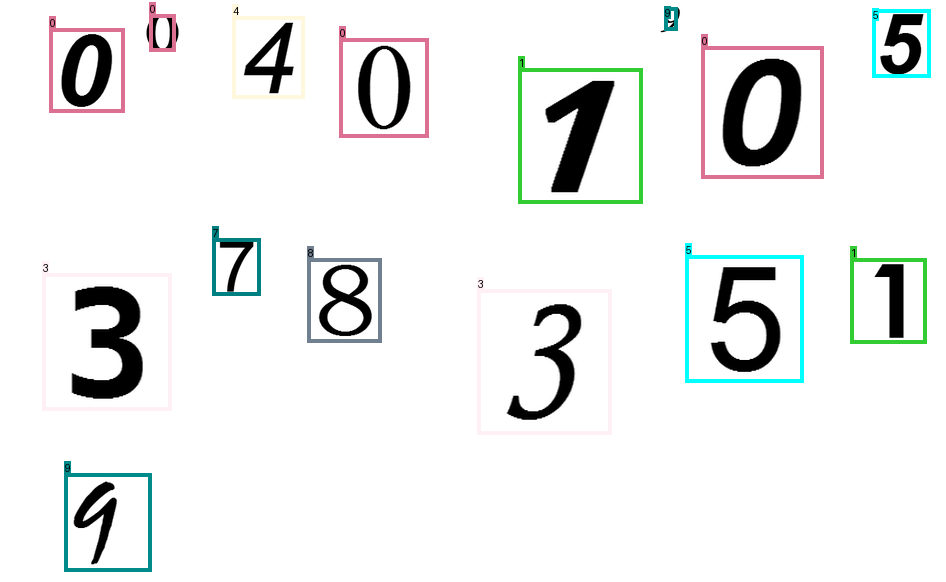



 43 >  cartel_010515471561670.txt
	 - 1 (0.045971, 0.080986, 0.027893, 0.086854) -> 0 (30, 16, 58, 52)
	 - 6 (0.181302, 0.275822, 0.104339, 0.260563) -> 1 (125, 62, 226, 173)
	 - 1 (0.369318, 0.207746, 0.141529, 0.34507) -> 0 (288, 14, 425, 161)
	 - 9 (0.563017, 0.20892, 0.095041, 0.239437) -> 5 (499, 37, 591, 140)
	 - 6 (0.679752, 0.190141, 0.070248, 0.183099) -> 1 (623, 41, 691, 120)
	 - 9 (0.749483, 0.083333, 0.021694, 0.07277) -> 5 (714, 19, 735, 50)
	 - 4 (0.801136, 0.057512, 0.021694, 0.07277) -> 4 (764, 9, 785, 40)
	 - 7 (0.848657, 0.078638, 0.025826, 0.08216) -> 7 (809, 15, 833, 50)
	 - 6 (0.124483, 0.67723, 0.139463, 0.340376) -> 1 (52, 215, 187, 361)
	 - 9 (0.314566, 0.806338, 0.139463, 0.340376) -> 5 (236, 270, 371, 416)
	 - 3 (0.490702, 0.661972, 0.082645, 0.211268) -> 6 (434, 236, 514, 327)
	 - 6 (0.61312, 0.611502, 0.06095, 0.161972) -> 1 (564, 225, 622, 294)
	 - 3 (0.690599, 0.557512, 0.034091, 0.100939) -> 6 (651, 216, 684, 259)
	 - 7 (0.770145, 0.66784, 0.079545, 0.2

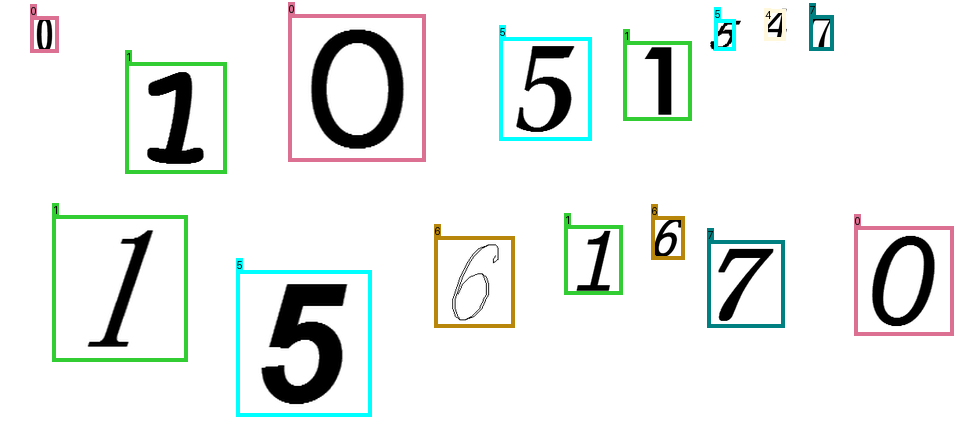



 44 >  cartel_986099006548944.txt
	 - 8 (0.043085, 0.09157, 0.037234, 0.130814) -> 9 (22, 9, 57, 54)
	 - 2 (0.195745, 0.25, 0.121277, 0.360465) -> 8 (127, 24, 241, 147)
	 - 3 (0.35, 0.186047, 0.06383, 0.203488) -> 6 (298, 29, 359, 99)
	 - 1 (0.469681, 0.190407, 0.067021, 0.212209) -> 0 (410, 29, 473, 101)
	 - 8 (0.610106, 0.239826, 0.105319, 0.31686) -> 9 (523, 28, 622, 137)
	 - 8 (0.802128, 0.226744, 0.112766, 0.337209) -> 9 (701, 19, 807, 135)
	 - 1 (0.906915, 0.167151, 0.041489, 0.142442) -> 0 (833, 32, 871, 81)
	 - 1 (0.97234, 0.084302, 0.023404, 0.093023) -> 0 (902, 12, 924, 44)
	 - 3 (0.073404, 0.598837, 0.082979, 0.255814) -> 6 (29, 161, 107, 249)
	 - 9 (0.280851, 0.767442, 0.138298, 0.406977) -> 5 (198, 194, 329, 334)
	 - 4 (0.426596, 0.69186, 0.07234, 0.226744) -> 4 (367, 198, 435, 276)
	 - 2 (0.545213, 0.585756, 0.060638, 0.194767) -> 8 (484, 168, 541, 234)
	 - 8 (0.634574, 0.556686, 0.028723, 0.107558) -> 9 (582, 173, 609, 209)
	 - 4 (0.72234, 0.627907, 0.093617, 0.284884)

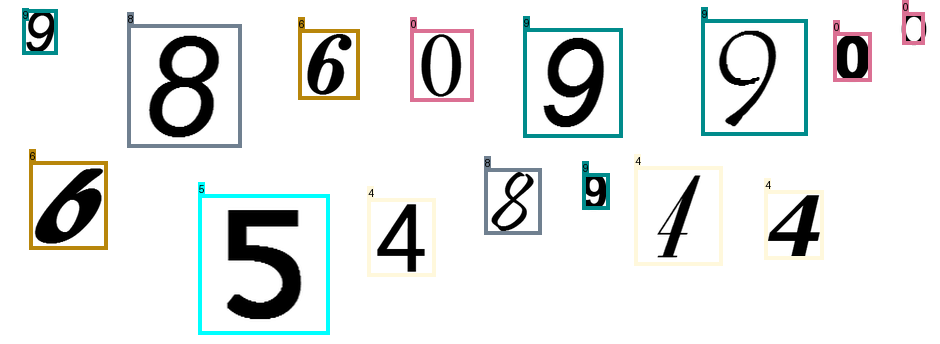



 45 >  cartel_873685792839196.txt
	 - 2 (0.088757, 0.362667, 0.114398, 0.336) -> 8 (31, 73, 147, 199)
	 - 7 (0.183925, 0.068, 0.02071, 0.082667) -> 7 (175, 9, 196, 41)
	 - 5 (0.237673, 0.074667, 0.029586, 0.106667) -> 3 (226, 8, 256, 48)
	 - 3 (0.316568, 0.189333, 0.084813, 0.256) -> 6 (277, 22, 364, 118)
	 - 2 (0.406805, 0.073333, 0.02071, 0.082667) -> 8 (402, 11, 423, 42)
	 - 9 (0.4714, 0.141333, 0.045365, 0.149333) -> 5 (454, 24, 500, 80)
	 - 7 (0.590237, 0.236, 0.07002, 0.216) -> 7 (563, 48, 634, 129)
	 - 8 (0.730769, 0.245333, 0.116371, 0.341333) -> 9 (681, 27, 799, 155)
	 - 0 (0.924556, 0.257333, 0.121302, 0.354667) -> 2 (875, 29, 998, 162)
	 - 2 (0.107495, 0.754667, 0.088757, 0.266667) -> 8 (64, 233, 153, 333)
	 - 5 (0.231755, 0.749333, 0.069034, 0.213333) -> 3 (199, 240, 269, 320)
	 - 8 (0.417653, 0.788, 0.127219, 0.370667) -> 9 (359, 225, 488, 365)
	 - 6 (0.532051, 0.66, 0.024655, 0.093333) -> 1 (526, 230, 551, 264)
	 - 8 (0.588757, 0.648, 0.021696, 0.085333) -> 9 (585, 227,

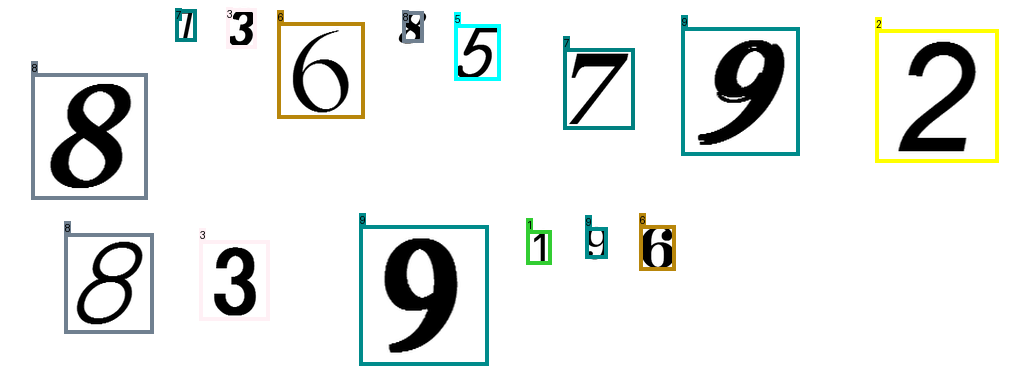



 46 >  cartel_891187748967472.txt
	 - 2 (0.062176, 0.123188, 0.041451, 0.120773) -> 8 (39, 25, 79, 75)
	 - 8 (0.140415, 0.097826, 0.030052, 0.094203) -> 9 (121, 20, 150, 59)
	 - 6 (0.245596, 0.277778, 0.107772, 0.275362) -> 1 (185, 58, 289, 172)
	 - 6 (0.345078, 0.060386, 0.02487, 0.082126) -> 1 (321, 7, 345, 41)
	 - 2 (0.45285, 0.178744, 0.074611, 0.198068) -> 8 (401, 32, 473, 115)
	 - 7 (0.581865, 0.310386, 0.127461, 0.321256) -> 7 (499, 61, 622, 194)
	 - 7 (0.72487, 0.216184, 0.100518, 0.258454) -> 7 (650, 36, 747, 143)
	 - 4 (0.85285, 0.169082, 0.055959, 0.154589) -> 4 (796, 38, 850, 101)
	 - 2 (0.954404, 0.183575, 0.060104, 0.164251) -> 8 (891, 42, 950, 110)
	 - 8 (0.07513, 0.805556, 0.125389, 0.316425) -> 9 (12, 268, 133, 399)
	 - 3 (0.262176, 0.804348, 0.136788, 0.342995) -> 6 (186, 262, 319, 404)
	 - 7 (0.438342, 0.789855, 0.099482, 0.256039) -> 7 (374, 273, 471, 380)
	 - 4 (0.526425, 0.618357, 0.031088, 0.096618) -> 4 (493, 235, 523, 275)
	 - 7 (0.577202, 0.630435, 0.02487, 

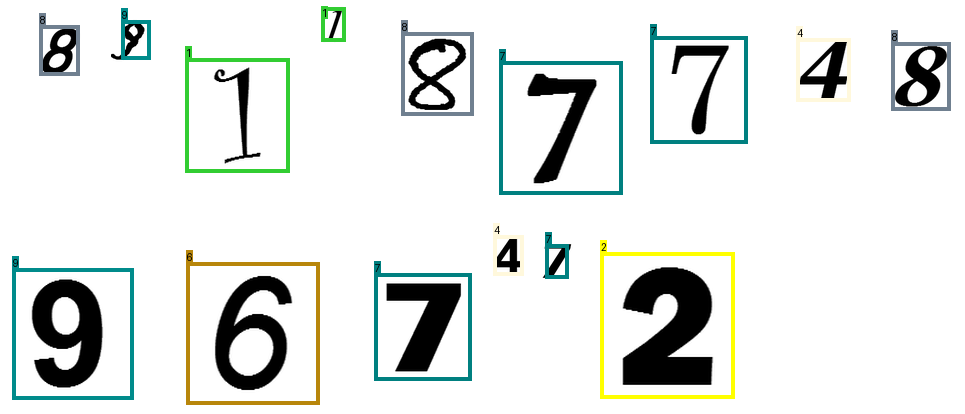



 47 >  cartel_549102787397347.txt
	 - 9 (0.093256, 0.294693, 0.09589, 0.282123) -> 5 (43, 55, 133, 156)
	 - 4 (0.21549, 0.146648, 0.053741, 0.170391) -> 4 (178, 21, 230, 82)
	 - 8 (0.357745, 0.361732, 0.140148, 0.399441) -> 9 (272, 58, 406, 200)
	 - 6 (0.574816, 0.21648, 0.127503, 0.365922) -> 1 (485, 11, 606, 142)
	 - 1 (0.738145, 0.303073, 0.123288, 0.354749) -> 0 (641, 45, 758, 172)
	 - 0 (0.850369, 0.136872, 0.048472, 0.156425) -> 2 (784, 21, 830, 77)
	 - 7 (0.954689, 0.167598, 0.059009, 0.184358) -> 7 (878, 27, 933, 93)
	 - 2 (0.067966, 0.73324, 0.085353, 0.25419) -> 8 (23, 216, 104, 307)
	 - 7 (0.195469, 0.72486, 0.076923, 0.231844) -> 7 (149, 217, 222, 300)
	 - 5 (0.269231, 0.643855, 0.013699, 0.064246) -> 3 (249, 219, 262, 242)
	 - 8 (0.326133, 0.738827, 0.038988, 0.131285) -> 9 (291, 241, 328, 288)
	 - 7 (0.404636, 0.824022, 0.071654, 0.217877) -> 7 (349, 255, 417, 333)
	 - 5 (0.545838, 0.804469, 0.115911, 0.335196) -> 3 (463, 227, 573, 347)
	 - 4 (0.656481, 0.662011, 0.0231

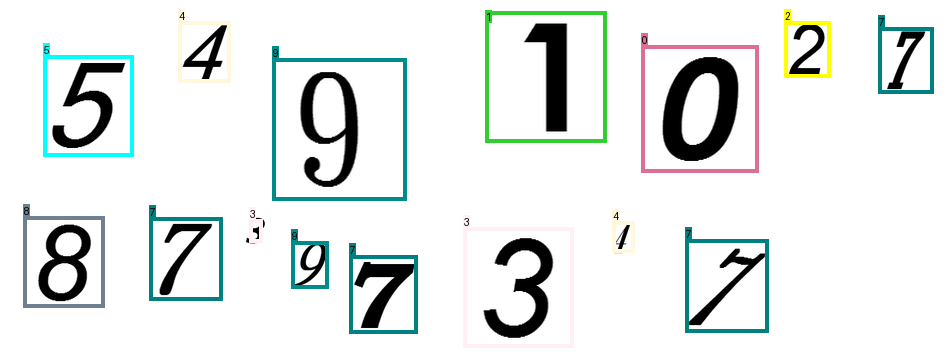



 48 >  cartel_583540556930125.txt
	 - 9 (0.027014, 0.101351, 0.028487, 0.105405) -> 5 (13, 17, 42, 56)
	 - 2 (0.09725, 0.159459, 0.056974, 0.183784) -> 8 (70, 24, 128, 92)
	 - 5 (0.194008, 0.195946, 0.091356, 0.278378) -> 3 (150, 21, 244, 123)
	 - 9 (0.290275, 0.131081, 0.052063, 0.17027) -> 5 (268, 17, 322, 79)
	 - 4 (0.396857, 0.3, 0.113949, 0.340541) -> 4 (346, 47, 462, 174)
	 - 1 (0.567289, 0.32027, 0.118861, 0.354054) -> 0 (516, 52, 638, 183)
	 - 9 (0.72053, 0.328378, 0.134578, 0.397297) -> 5 (664, 47, 801, 194)
	 - 9 (0.833497, 0.07973, 0.022593, 0.089189) -> 5 (837, 13, 859, 46)
	 - 3 (0.927308, 0.367568, 0.115914, 0.345946) -> 6 (884, 72, 1002, 200)
	 - 8 (0.037819, 0.641892, 0.036346, 0.127027) -> 9 (19, 214, 56, 261)
	 - 5 (0.158644, 0.768919, 0.124754, 0.37027) -> 3 (97, 216, 224, 352)
	 - 1 (0.255403, 0.62973, 0.013752, 0.064865) -> 0 (253, 221, 267, 245)
	 - 6 (0.32613, 0.708108, 0.082515, 0.254054) -> 1 (290, 214, 374, 308)
	 - 0 (0.446464, 0.804054, 0.112967, 0.337838)

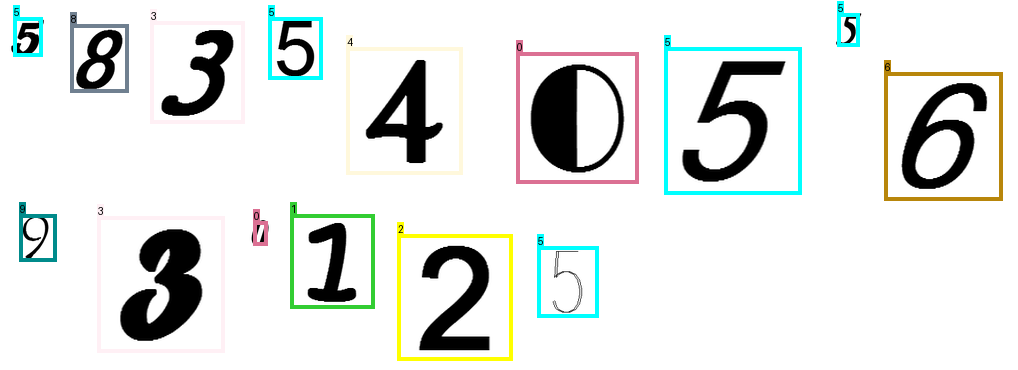



 49 >  cartel_246570658672080.txt
	 - 0 (0.105289, 0.277778, 0.100798, 0.262411) -> 2 (54, 62, 155, 173)
	 - 4 (0.192615, 0.070922, 0.01996, 0.070922) -> 4 (183, 15, 203, 45)
	 - 3 (0.291916, 0.138298, 0.062874, 0.172577) -> 6 (260, 22, 323, 95)
	 - 9 (0.423653, 0.22104, 0.112774, 0.29078) -> 5 (368, 31, 481, 154)
	 - 7 (0.556886, 0.224586, 0.107784, 0.27896) -> 7 (503, 35, 611, 153)
	 - 1 (0.737026, 0.228132, 0.136727, 0.347518) -> 0 (669, 22, 807, 169)
	 - 3 (0.924152, 0.238771, 0.121756, 0.312057) -> 6 (865, 35, 987, 167)
	 - 9 (0.14521, 0.72695, 0.128743, 0.328605) -> 5 (81, 237, 210, 376)
	 - 2 (0.244511, 0.546099, 0.025948, 0.085106) -> 8 (232, 212, 257, 248)
	 - 3 (0.347305, 0.588652, 0.077844, 0.208038) -> 6 (308, 204, 386, 292)
	 - 7 (0.422156, 0.51773, 0.011976, 0.052009) -> 7 (417, 207, 429, 229)
	 - 0 (0.537924, 0.687943, 0.113772, 0.293144) -> 2 (482, 228, 595, 352)
	 - 1 (0.691118, 0.807329, 0.132735, 0.338061) -> 0 (626, 270, 759, 413)
	 - 2 (0.798403, 0.550827, 0.0199

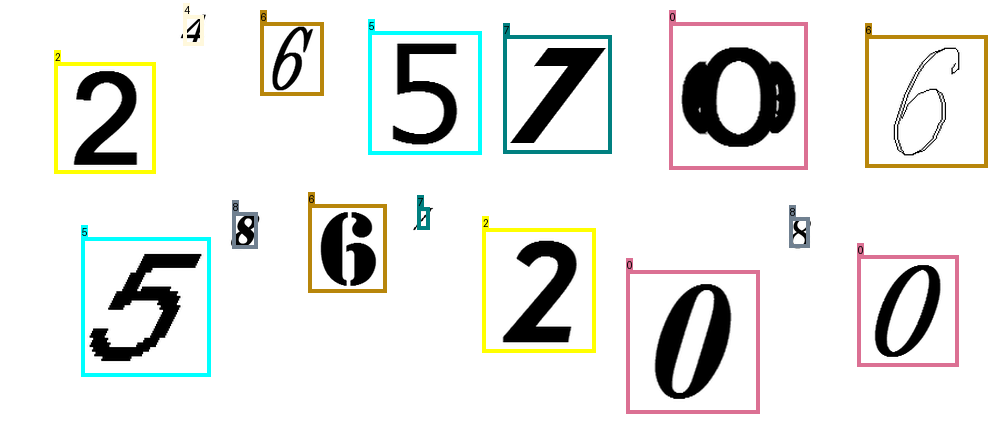



 50 >  cartel_200946662856320.txt
	 - 0 (0.073545, 0.167674, 0.092063, 0.293051) -> 2 (26, 7, 112, 104)
	 - 1 (0.168254, 0.102719, 0.027513, 0.108761) -> 0 (146, 16, 171, 51)
	 - 1 (0.23545, 0.143505, 0.049735, 0.172205) -> 0 (199, 19, 246, 76)
	 - 8 (0.306878, 0.178248, 0.046561, 0.163142) -> 9 (267, 32, 311, 86)
	 - 4 (0.379365, 0.167674, 0.047619, 0.166163) -> 4 (335, 28, 380, 83)
	 - 3 (0.505291, 0.276435, 0.134392, 0.413897) -> 6 (413, 23, 541, 159)
	 - 3 (0.646032, 0.134441, 0.051852, 0.178248) -> 6 (586, 14, 635, 74)
	 - 3 (0.77672, 0.166163, 0.088889, 0.283988) -> 6 (692, 7, 776, 101)
	 - 0 (0.924868, 0.253776, 0.118519, 0.36858) -> 2 (818, 22, 930, 144)
	 - 2 (0.052381, 0.717523, 0.056085, 0.190332) -> 8 (22, 206, 76, 269)
	 - 9 (0.173016, 0.811178, 0.100529, 0.317221) -> 5 (116, 215, 211, 320)
	 - 3 (0.292593, 0.744713, 0.073016, 0.238671) -> 6 (242, 206, 311, 286)
	 - 5 (0.384127, 0.667674, 0.035979, 0.132931) -> 3 (345, 199, 380, 243)
	 - 0 (0.52381, 0.791541, 0.091005, 0

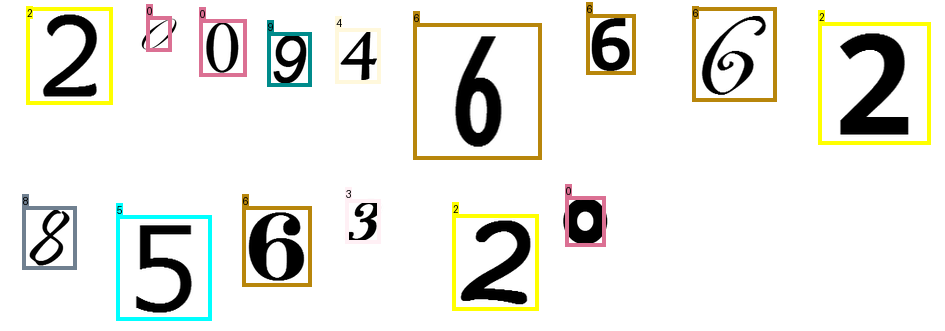



== Cantidad de LABELs mostrados:  50


In [9]:
#@title Probar LABELs generadas

# vuelve a ordenar la lista para mostrar bien
all_label_array.sort()

# arma hash para contar tipo objetos
diccTipoObjCant = {}

def draw_text_on_img(draw, display_str_list, box, color):
  (left, top, right, bottom) = box
  try:
    font = ImageFont.truetype('arial.ttf', 24)
  except IOError:
    font = ImageFont.load_default()
  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top # - total_display_str_height
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                          text_bottom)],
        fill=color)
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill='black',
        font=font)
    text_bottom -= text_height - 2 * margin
    return

def draw_box_on_image(draw, box, color, className=None, line_width=5):
    # dibuja en la imagen
    draw.rectangle(box, outline=color, width=line_width)
    # si tiene que incluir nombre clase
    if className is not None:
      draw_text_on_img(draw, [className], box, color)

def load_LABEL(labelFN):
  if not os.path.isfile(labelFN):
    print("\t ERROR: no se encuentra el archivo ", labelFN, " disponible!")
    return []
  with open(labelFN, 'r') as f:
    data = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      auxi = line.split(" ")
      class_id = int(auxi[0])
      v1 = float(auxi[1])
      v2 = float(auxi[2])
      v3 = float(auxi[3])
      v4 = float(auxi[4])
      data.append( (class_id, v1, v2, v3, v4) )
  return data

# variable auxiliar
cantProcesados = 0
# procesa los XMLs
for label_file in mostrar_label_array: #all_label_array:
    # variables auxiliares para chequear duplicados

    cantProcesados = cantProcesados + 1
    if not os.path.isfile(data_dir_path + '/' + label_file):
      print("\n\n", cantProcesados,"> ", label_file)
      print("\tno se encuentra el archivo LABEL!")
      continue

    # decide si muestra la imagen asociada a este XML
    muestraImagen = ((label_file in mostrar_label_array) and mostrarObjetosEnImagen)

    # carga la info del LABEL
    image_filename = os.path.splitext(label_file)[0] + '.png'
    img_filename = os.path.join(image_dir_path, image_filename)
    if not os.path.isfile(img_filename):
      print("\n\n", cantProcesados,"> ", label_file)
      print("\tno se encuentra la imagen ", img_filename, "!")
      continue

    if muestraImagen or mostrarImagenOriginal:
      print("\n\n", cantProcesados,"> ", label_file)
      # carga la imagen
      imageCargada = ImPIL.open(img_filename)

      if mostrarImagenOriginal:
          display( imageCargada )

      if muestraImagen:

          # imagen auxiliar para mostrar recuadros y obtener tamaño
          img = tf.io.read_file(img_filename)
          img = tf.image.decode_jpeg(img, channels=3)
          img = img.numpy()
          image_pil = Image.fromarray(np.uint8(img)).convert("RGB")
          im_width, im_height = image_pil.size
          draw = ImageDraw.Draw(image_pil)

          labelDataList = load_LABEL(data_dir_path + '/' + label_file)
          for d in labelDataList:
              class_id = d[0]
              if (class_id>=len(class_list)) or (class_id<0):
                class_name = str(class_id)
              else:
                class_name = class_list[class_id]

              # convierte a box para poder mostrarlo
              box = convert_yolo_to_bbox((d[1], d[2], d[3], d[4]), (im_width, im_height))

              print("\t -", d[0], d[1:], "->", class_name, box)

              # genera los recuadros correspondientes
              color = colors[(hash(class_name)) % len(colors)]
              if color == "#ffffff":
                color = "#000000"
              # dibuja el recuadro en la imagen
              draw_box_on_image(draw, box, color, class_name, line_width=4)

          print("\n")
          imMostrar = Image.fromarray(np.array(image_pil))#, 'RGB')
          display( imMostrar )

print("\n\n== Cantidad de LABELs mostrados: ", cantProcesados)


